In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
c0 = -1
c1 = 0.7
c2 = 0.3
c3 = 3
c4 = 0.5
alpha = 1

def true_loss_function(theta):
    return c0 * np.cos(c1*theta) + c2 * np.sin(c3 * (theta - c4))

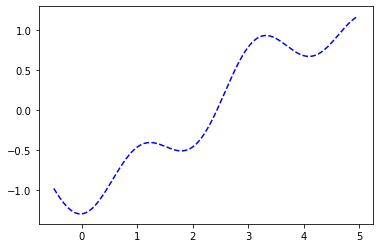

In [3]:
# evenly sampled time at 200ms intervals
mus = np.arange(-0.5, 5., 0.02)

# red dashes, blue squares and green triangles
plt.plot(mus, true_loss_function(mus), 'b--')
plt.show()

In [4]:
import jax
import jax.numpy as jnp
import jaxopt

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

def conservative_loss(param, logging_samples, logging_losses, logging_propensities):
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean + std

def optimist_loss(param, logging_samples, logging_losses, logging_propensities):
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean - std


In [5]:
def safe_optimize(loss_fun, init_parameter, logging_loss_threshold, confidence_region, args):

    lbfgsb = jaxopt.ScipyBoundedMinimize(fun=loss_fun, method="l-bfgs-b")

    min_mu = mus[confidence_region].min()
    max_mu = mus[confidence_region].max()

    lower_bounds = jnp.array(min_mu, dtype='float32')
    upper_bounds = jnp.array(max_mu, dtype='float32')
    bounds = (lower_bounds, upper_bounds)

    lbfgsb_sol = lbfgsb.run(init_parameter, bounds, *args).params
    return lbfgsb_sol

In [6]:

def plot_dynamic(estimates, optimized_mus, mode='conservative'):
    
    ### Estimates
    estimate_means = estimates['means']
    estimate_stds = estimates['stds']
    ess_diagnostics = estimates['ess']
#     upper_bounds = estimate_means+estimate_stds
    confidence_region = estimates['confidence_region']
    number_episodes = len(optimized_mus)
    
    ### Create figure
    plt.figure(figsize=(16, 12))

    ### Loss function and its estimate, its confidence bound
    plt.plot(mus, true_loss_function(mus), 'b-.', label='loss function')
    plt.plot(mus, estimate_means, '-.', label='estimated loss')
    plt.fill_between(mus, (estimate_means-estimate_stds), (estimate_means+estimate_stds), color='b', alpha=.1, label='confidence set')

    ### Confidence/constrained region
    plt.axhline(y=logging_loss_threshold, color='purple', linestyle='-', label=r'$(1+\varepsilon)L(\mu_0)$')
    plt.fill_between(mus, -3.5, 2.5, where=(ess_diagnostics<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
    plt.fill_between(mus, -3.5, 2.5, where=confidence_region,
                    color='lightgreen', alpha=0.5, label='safe region')

    ### Logging mu and associates
    for index in range(number_episodes-1):
        mu = optimized_mus[index]
        plt.axvline(x=mu, color='limegreen', linestyle='--', label=r'$\mu_{}$'.format(index))
    index, mu = len(optimized_mus)-1, optimized_mus[-1] # last value is in black
    plt.axvline(x=mu, color='k', linestyle='--', label=r'$\mu_{}$'.format(index))

    ### Legends, labels, ticks, save figure
    plt.legend(loc='upper left')
    plt.xlabel(r'$\mu$')
    ticks_x, ticks_label = [0, 2], ['0', '2']
    ticks_x += optimized_mus
    ticks_label += ['$\mu_{}$'.format(index) for index in range(number_episodes)]
    plt.xticks(ticks_x, ticks_label)
    plt.ylim(-3.5, 2.5)
    plt.title('Rollout {} - {} loss'.format(number_episodes-1, mode))
    plt.savefig('{}_scrm_{}.pdf'.format(mode, number_episodes-1))
    plt.show()

### Data

In [7]:
logging_mu = 3
logging_scale = 0.3
n_samples = 10000
rng = np.random.RandomState(123)
logging_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
logging_losses = true_loss_function(logging_samples)
logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
logging_propensities = logging_pdf(logging_samples)
logging_loss = np.mean(logging_losses)
epsilon = 0.9
logging_loss_threshold = logging_loss*(1+epsilon)
logging_data = logging_samples, logging_losses, logging_propensities

mu = logging_mu
optimized_mus = [mu]
M = 15

In [8]:
epsilon = 0.2
logging_loss_threshold = logging_loss*(1+epsilon)
lambd = 30

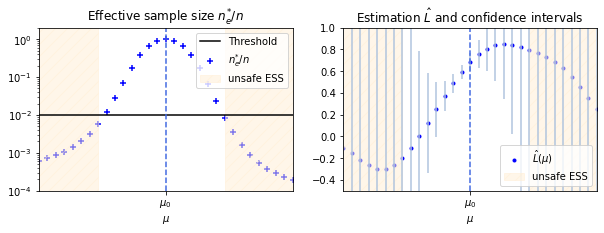

In [9]:
logging_data = logging_samples, logging_losses, logging_propensities
mus = np.arange(-0.5, 5., 0.1)

def get_estimates(mu, logging_data):

    def estimates(mu, logging_data):
        logging_samples, logging_losses, logging_propensities = logging_data
        running_pdf = norm(loc=mu, scale=logging_scale).pdf
        ### DANGER ICI LES PROPENSITIES SONT FAUSSES
        importance_weights = running_pdf(logging_samples)/logging_pdf(logging_samples)
        ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
        return np.mean(logging_losses * importance_weights), lambd*np.std(logging_losses * importance_weights)/np.sqrt(n_samples), ess_diagnostic

    estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
    estimate_means, ess_diagnostics = np.array(estimate_means), np.array(ess_diagnostics)
    upper_bounds = estimate_means+estimate_stds
    confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

    estimates = {
        'means': estimate_means,
        'stds': estimate_stds,
        'ess': ess_diagnostics,
        'confidence_region': confidence_region
    }

    return estimates

estimates = get_estimates(mu, logging_data)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

lambd = logging_samples.mean()


# axs[0].plot(nus, ne_star, c='black', label='$n^{*}_{e}/n$')
axs[0].scatter(mus, estimates['ess'], c='blue', marker='+', label='$n^{*}_{e}/n$')
axs[0].set_yscale('log')
axs[0].fill_between(mus, 0.0001, 2, where=(estimates['ess']<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
axs[0].set_ylim(0.0001, 2)

axs[0].set_xlabel('$\mu$')
axs[0].set_title('Effective sample size $n^{*}_{e}/n$')
# axs[0].axhline(0.01*n, linestyle='--', label='$0.01*n$', c='navy')
axs[0].plot(mus, 0.01*np.ones_like(mus), c='black', label='Threshold')
axs[0].axvline(lambd, linestyle='--', c='royalblue')
axs[0].legend(loc='upper right')
axs[0].set_xticks([logging_mu])

axs[1].scatter(mus, estimates['means'], marker='.', color='blue', label='$\hat{L}(\mu)$')
axs[1].errorbar(mus, estimates['means'], yerr=estimates['stds'], linestyle='', color='lightsteelblue')
axs[1].set_xlabel('$\mu$')
axs[1].set_title('Estimation $\hat{L}$ and confidence intervals')
axs[1].axvline(lambd, linestyle='--', c='royalblue')
axs[1].fill_between(mus, -0.5, 1, where=(estimates['ess']<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
axs[1].set_ylim(-0.5, 1)
axs[1].legend(loc='lower right')
axs[1].set_xticks([logging_mu])
# axs[2].scatter(nus, empirical_means, color='blue', label='Empirical mean')
# axs[2].plot(nus, np.ones_like(nus), c='black', label='Theoretical mean')
# axs[2].set_xlabel('$\mu$')
# axs[2].set_title('Importance sampling weights mean $\dfrac{1}{n} \sum w_i$')
# axs[2].axvline(lambd, linestyle='--', label='$\mu_{\pi_0}$ mode', c='royalblue')
# axs[2].legend(loc='lower right')
axs[0].set_xlim(1.5, 4.5)
axs[1].set_xlim(1.5, 4.5)

plt.setp(axs, xticks=[logging_mu],
         xticklabels=['$\mu_0$'])
plt.savefig('diagnostics.pdf',  pad_inches=0, bbox_inches='tight')


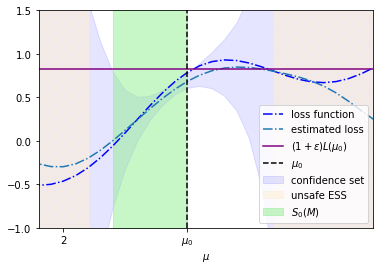

In [10]:
### Estimates
estimate_means = estimates['means']
estimate_stds = estimates['stds']
ess_diagnostics = estimates['ess']
#     upper_bounds = estimate_means+estimate_stds
confidence_region = estimates['confidence_region']

y_low = -1
y_up = 1.5
### Create figure
# plt.figure(figsize=(16, 12))

### Loss function and its estimate, its confidence bound
plt.plot(mus, true_loss_function(mus), 'b-.', label='loss function')
plt.plot(mus, estimate_means, '-.', label='estimated loss')
plt.fill_between(mus, (estimate_means-estimate_stds), (estimate_means+estimate_stds), color='b', alpha=.1, label='confidence set')

### Confidence/constrained region
plt.axhline(y=logging_loss_threshold, color='purple', linestyle='-', label=r'$(1+\varepsilon)L(\mu_0)$')
plt.fill_between(mus, y_low, y_up, where=(ess_diagnostics<0.01), hatch='//', edgecolor='black', color='papayawhip', alpha=0.5, label='unsafe ESS')
plt.fill_between(mus, y_low, y_up, where=confidence_region,
                color='lightgreen', alpha=0.5, label='$S_0(M)$')

### Logging mu and associates
plt.axvline(x=logging_mu, color='k', linestyle='--', label=r'$\mu_0$')

### Legends, labels, ticks, save figure
plt.legend(loc='lower right')
plt.xlabel(r'$\mu$')
plt.xlim(1.8, 4.5)
ticks_x, ticks_label = [2, logging_mu], ['2', '$\mu_0$']
plt.xticks(ticks_x, ticks_label)
plt.ylim(y_low, y_up)
# plt.title('Rollout {} - {} loss'.format(number_episodes-1, mode))
plt.savefig('safe_crm.pdf')
plt.show()

# Conservative

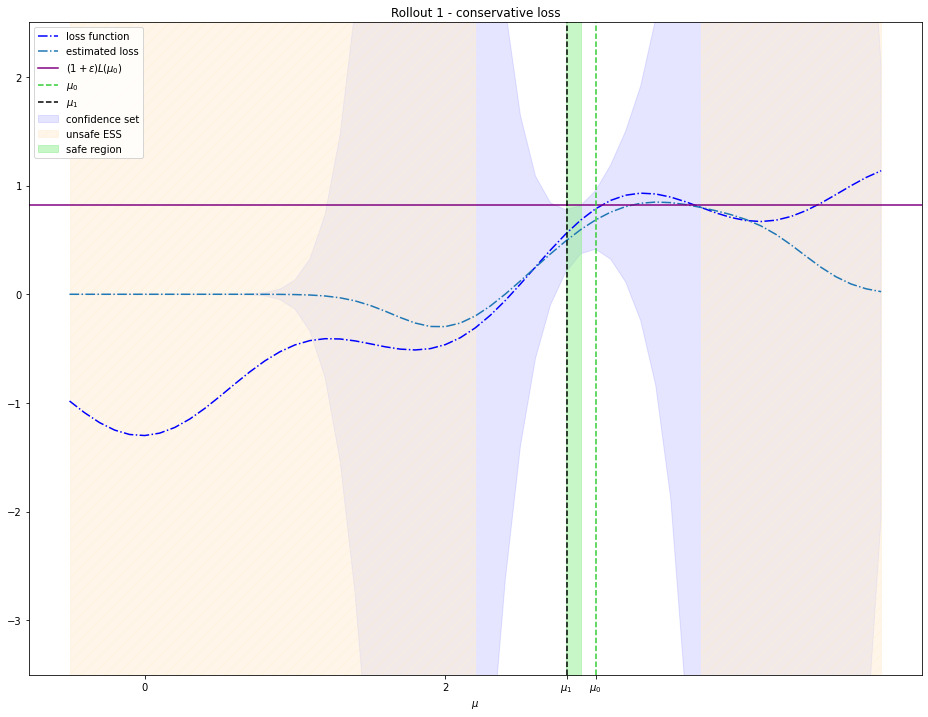

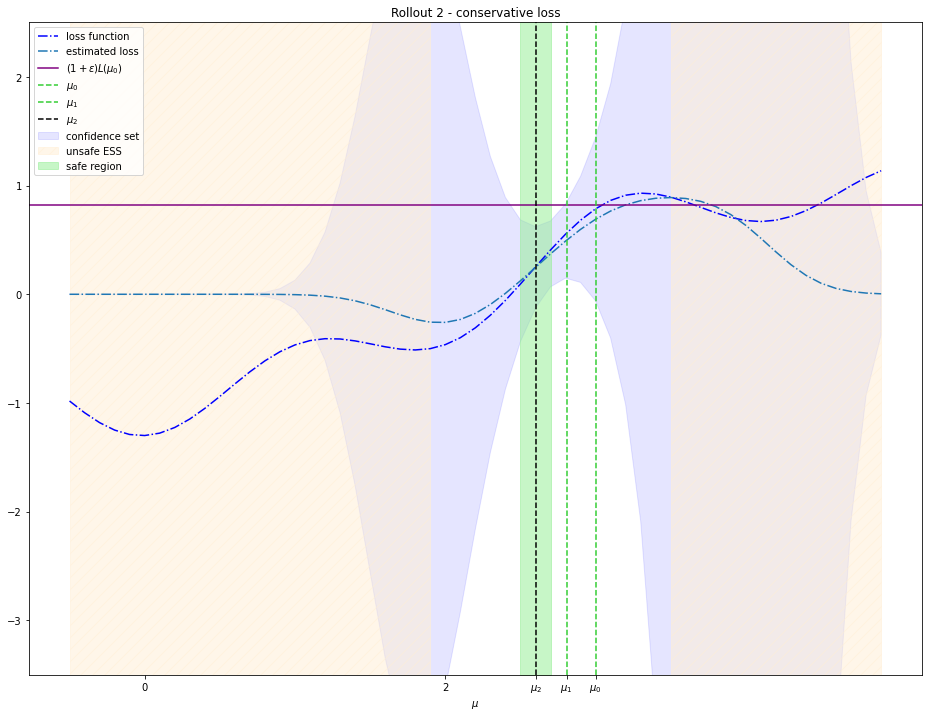

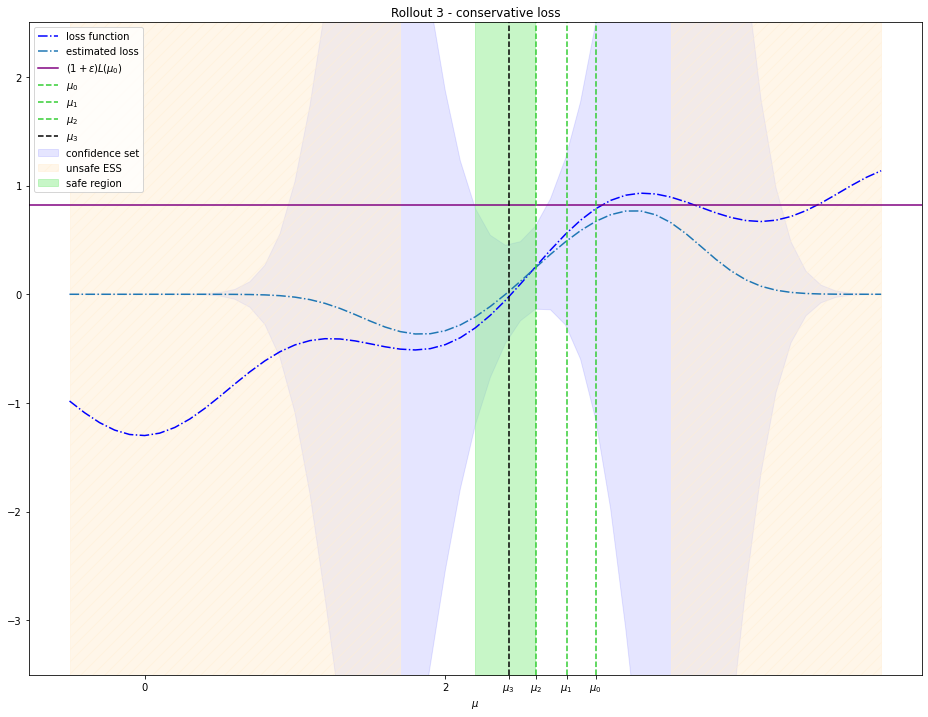

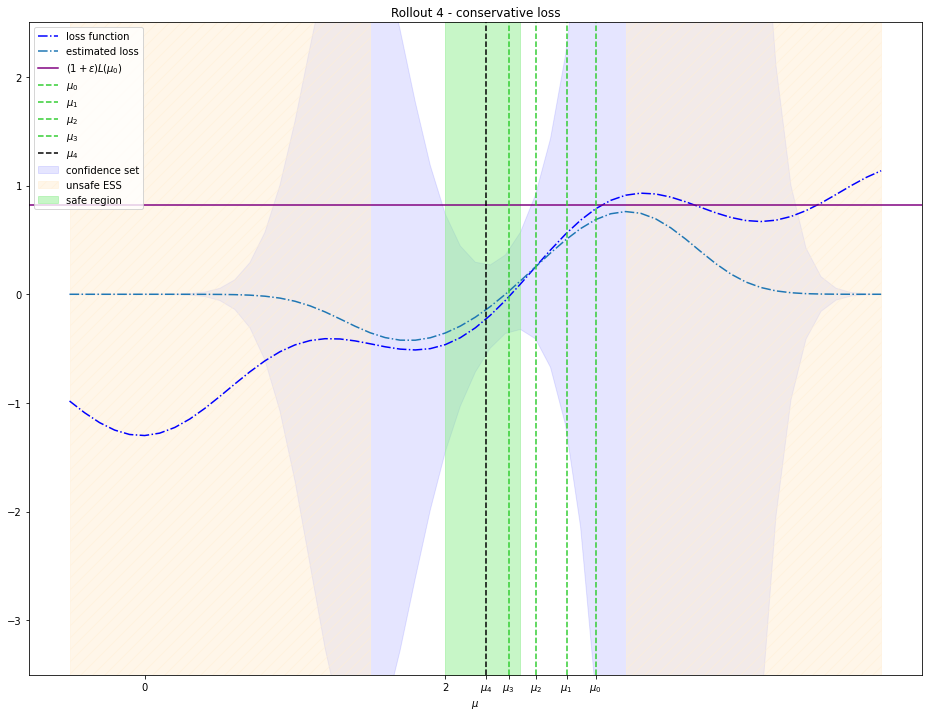

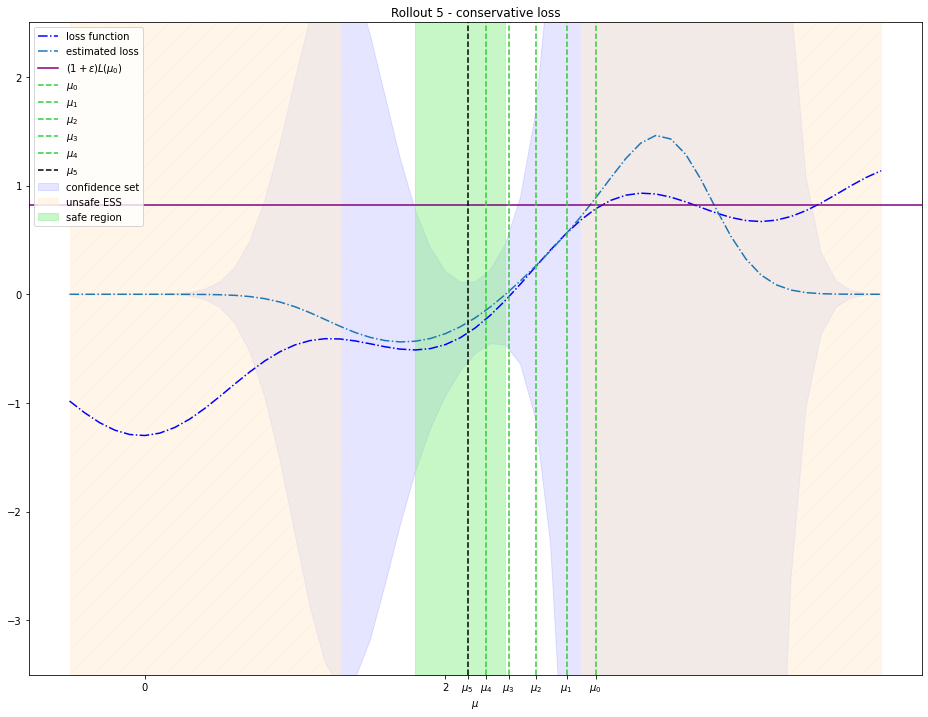

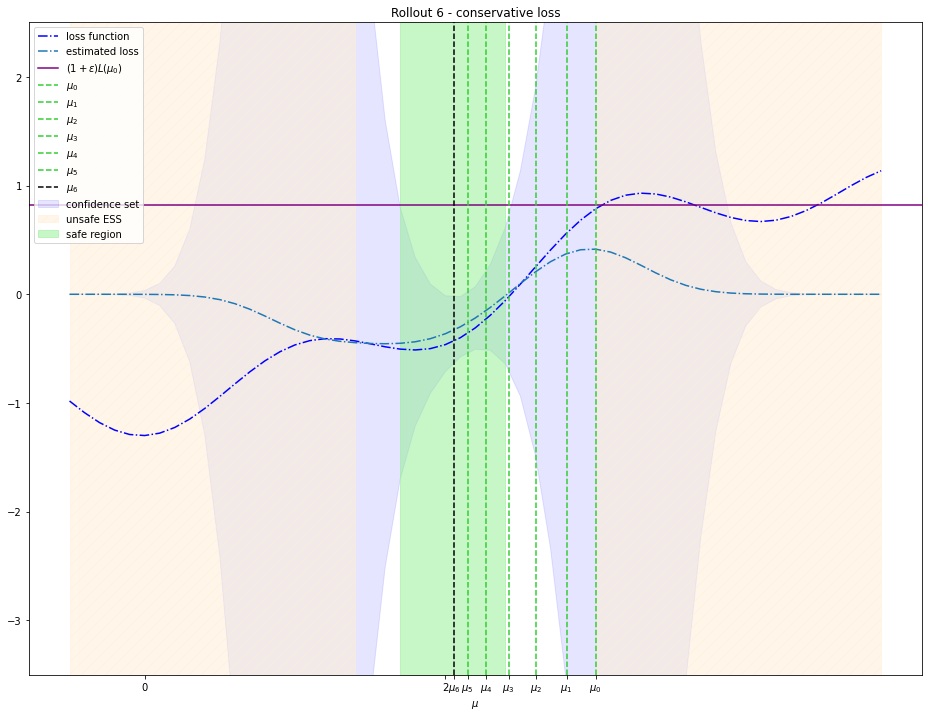

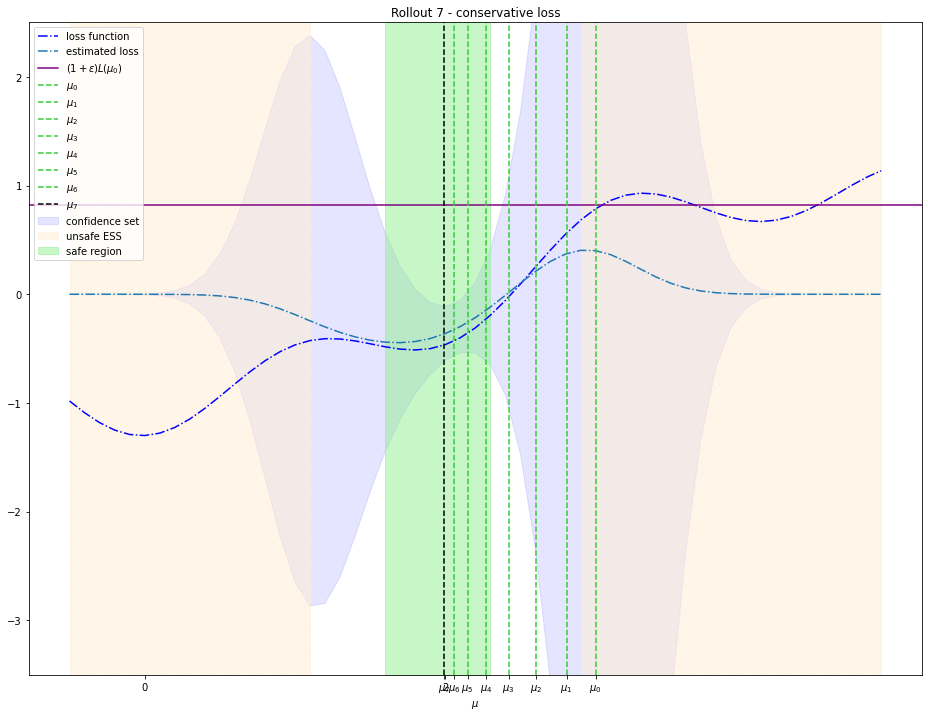

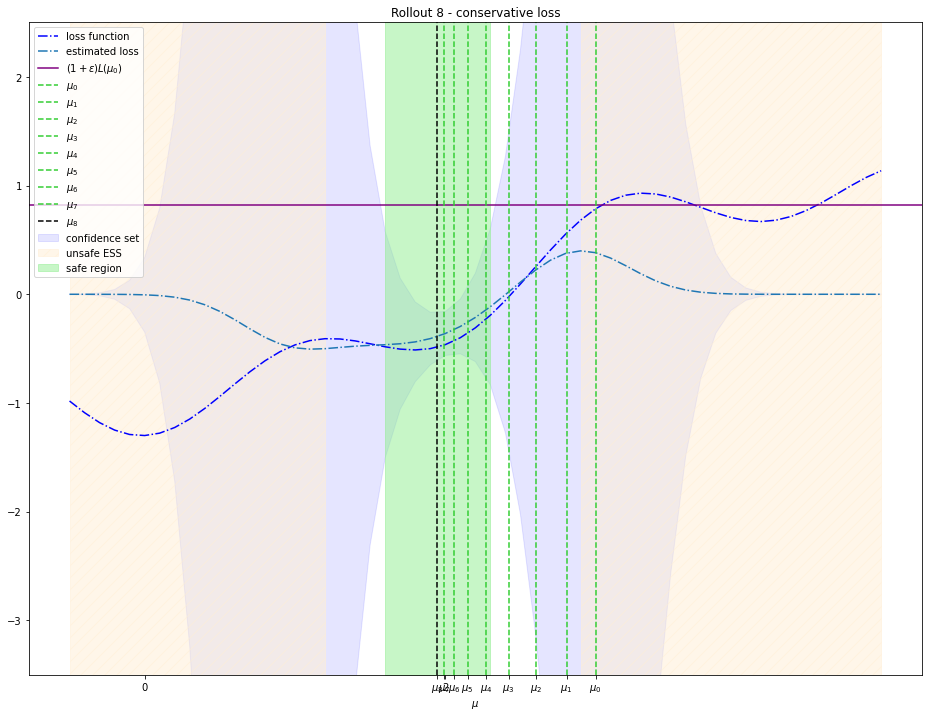

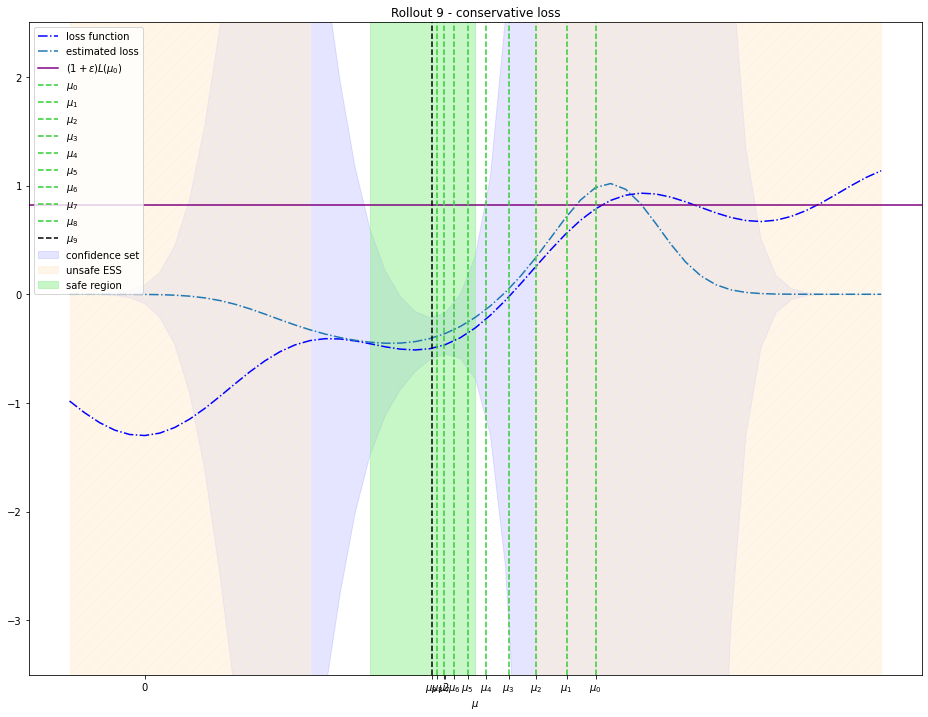

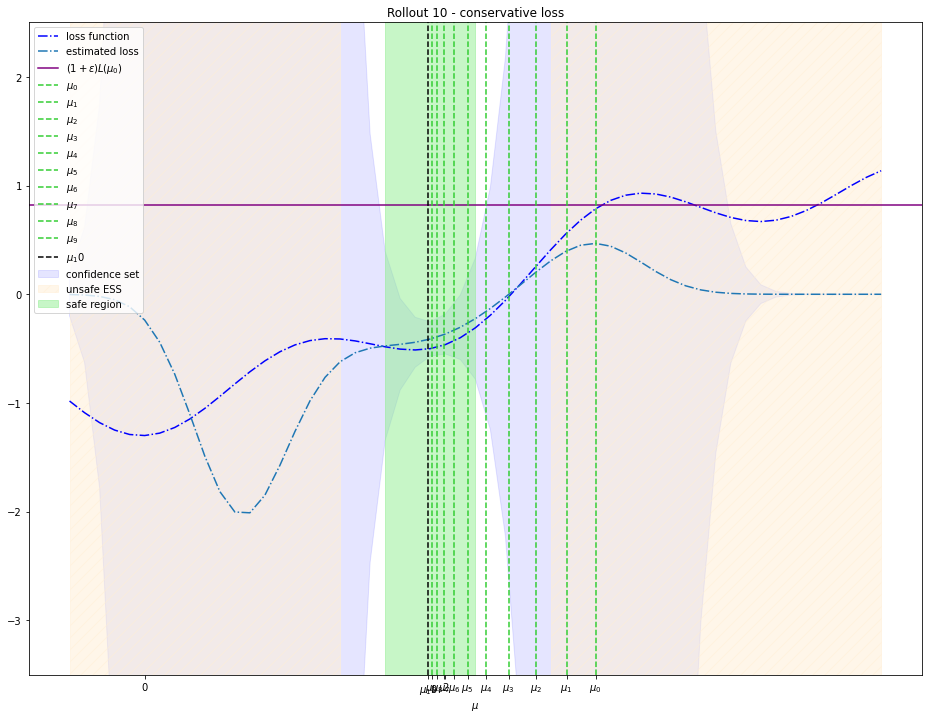

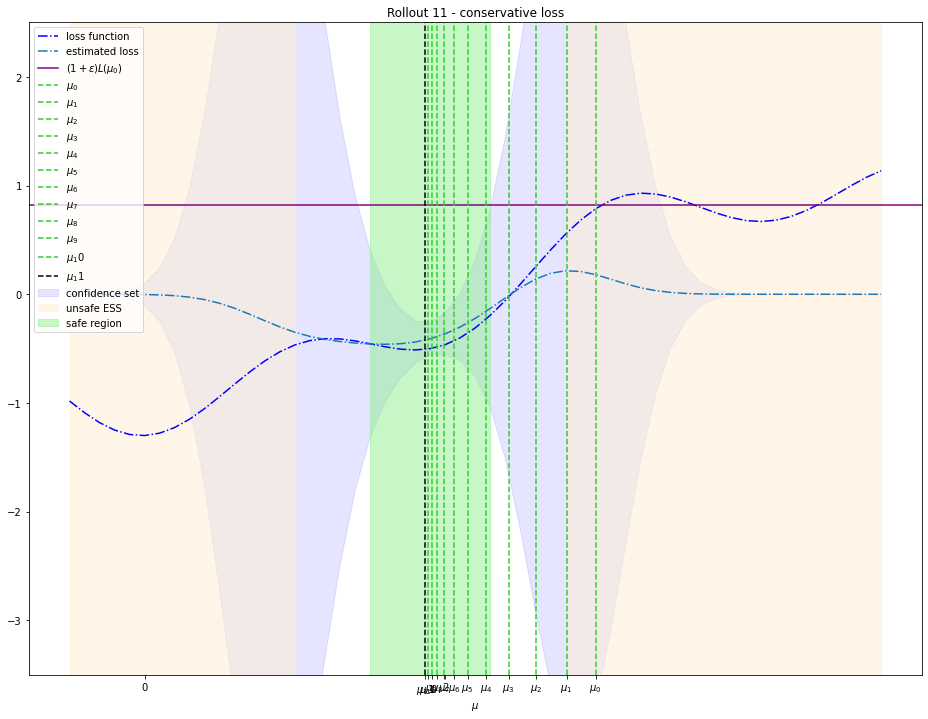

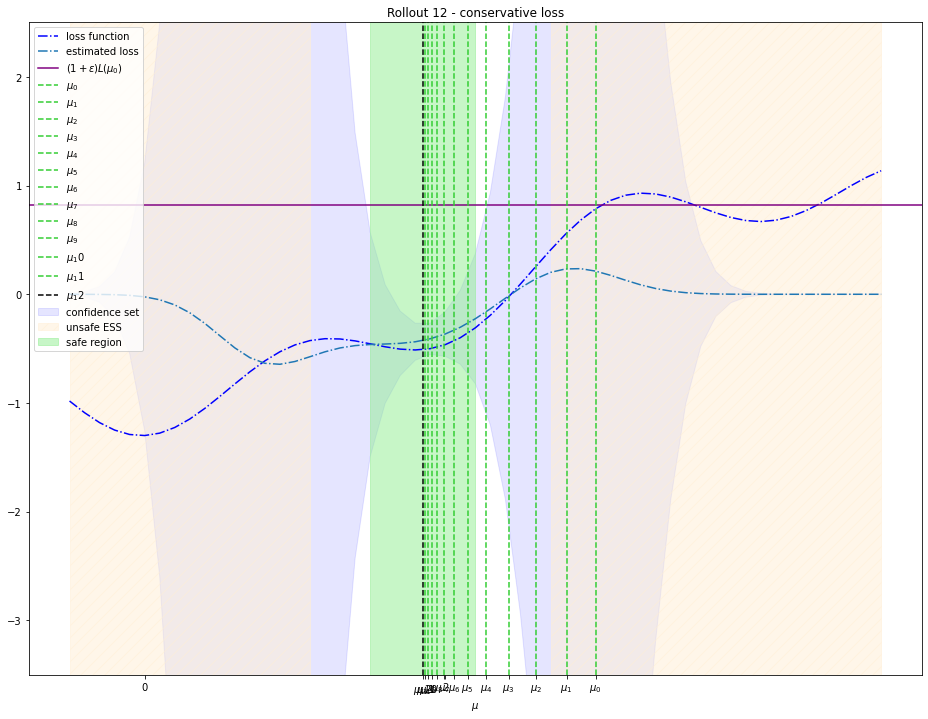

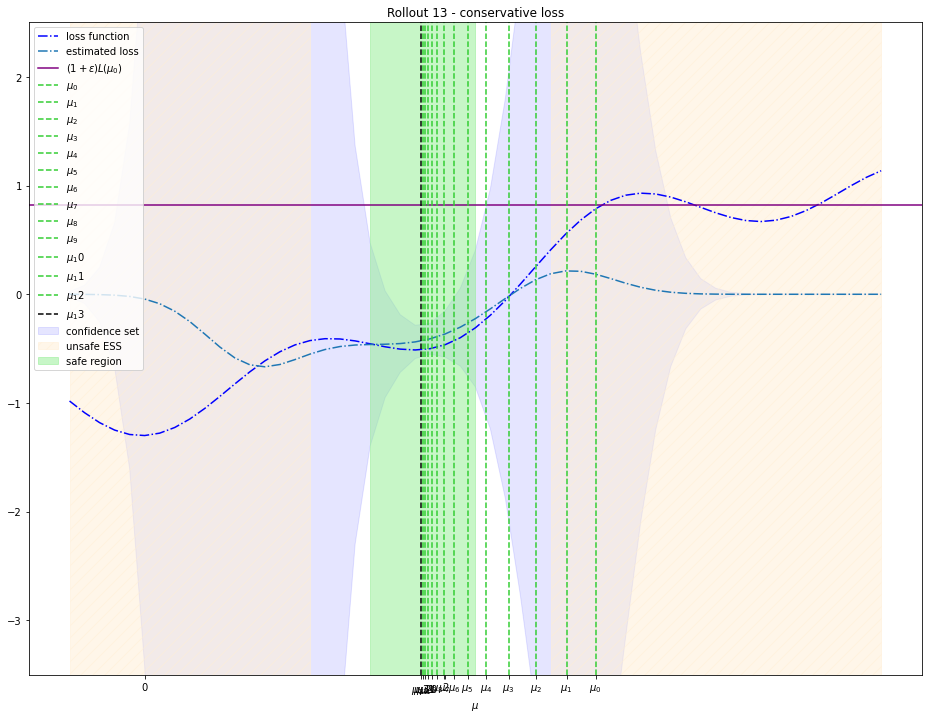

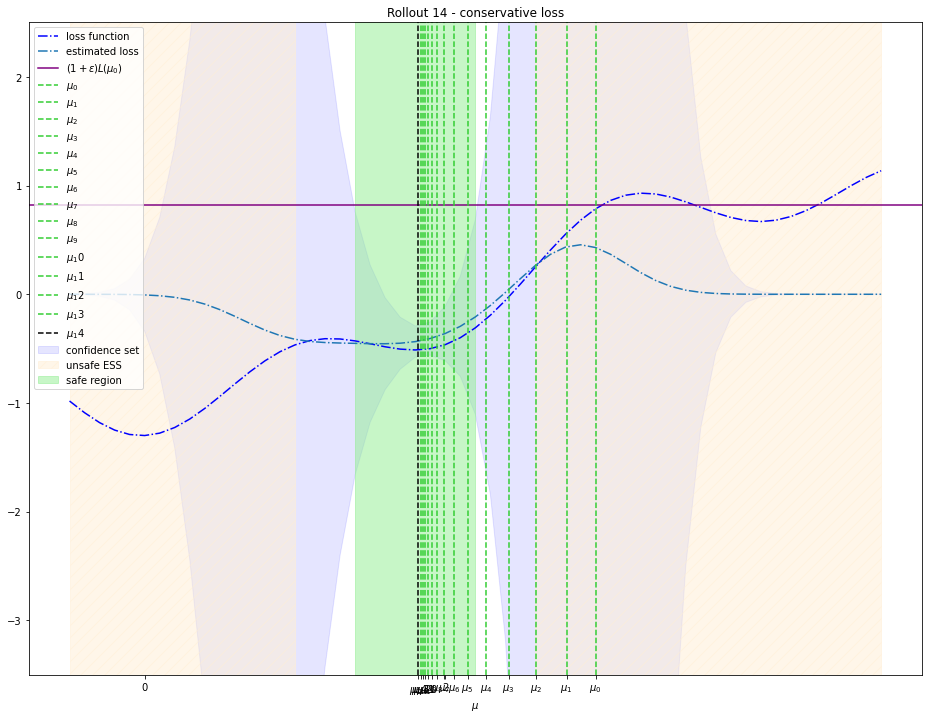

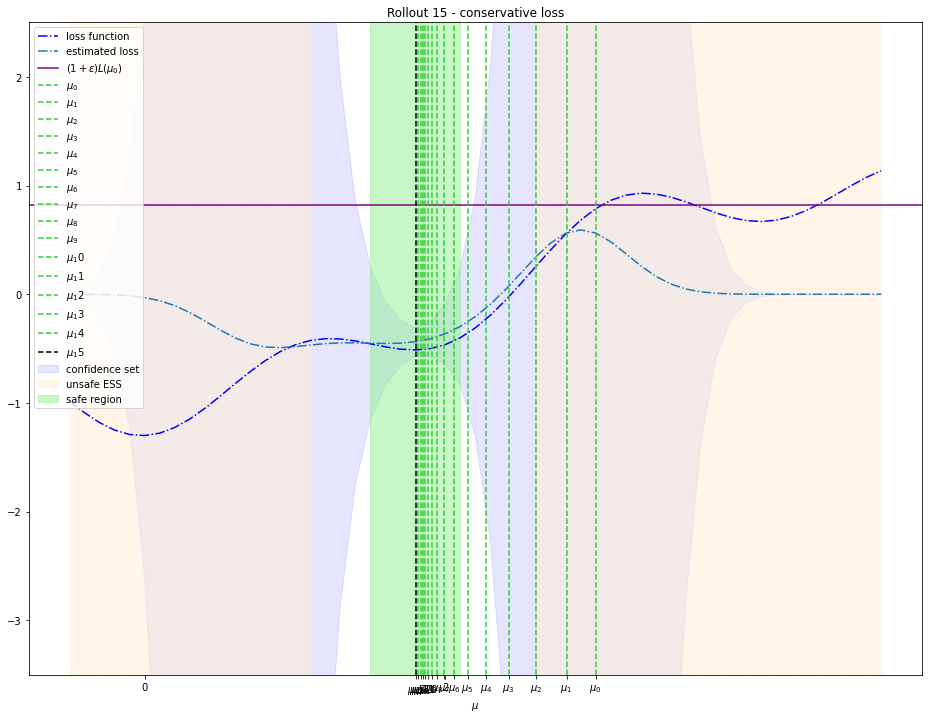

In [11]:
mode = 'conservative'
loss_fun = conservative_loss

for m in range(M):

    logging_data = logging_samples, logging_losses, logging_propensities

    def get_estimates(mu, logging_data):

        def estimates(mu, logging_data):
            logging_samples, logging_losses, logging_propensities = logging_data
            running_pdf = norm(loc=mu, scale=logging_scale).pdf
            ### DANGER ICI LES PROPENSITIES SONT FAUSSES
            importance_weights = running_pdf(logging_samples)/logging_pdf(logging_samples)
            ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
            return np.mean(logging_losses * importance_weights), np.std(logging_losses * importance_weights), ess_diagnostic

        estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
        estimate_means, ess_diagnostics = np.array(estimate_means), np.array(ess_diagnostics)
        upper_bounds = estimate_means+estimate_stds
        confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

        estimates = {
            'means': estimate_means,
            'stds': estimate_stds,
            'ess': ess_diagnostics,
            'confidence_region': confidence_region
        }

        return estimates

    estimates = get_estimates(mu, logging_data)
    confidence_region = estimates['confidence_region']
    init_parameter = jnp.array(mu, dtype='float32')
    args = logging_data

    optimized_mu = safe_optimize(loss_fun, init_parameter, logging_loss_threshold, confidence_region, args)
    optimized_mus.append(optimized_mu)
    plot_dynamic(estimates, optimized_mus)

    ### New logging data
    mu = optimized_mu._value
    logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
    logging_losses = true_loss_function(logging_samples)
    logging_pdf = norm(loc=mu, scale=logging_scale).pdf
    logging_propensities = logging_pdf(logging_samples)

# Optimist

In [9]:
logging_mu = 3
logging_scale = 0.3
n_samples = 10000
rng = np.random.RandomState(123)
logging_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
logging_losses = true_loss_function(logging_samples)
logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
logging_propensities = logging_pdf(logging_samples)
logging_loss = np.mean(logging_losses)
epsilon = 0.9
logging_loss_threshold = logging_loss*(1+epsilon)
logging_data = logging_samples, logging_losses, logging_propensities

mu = logging_mu
optimized_mus = [mu]
M = 15

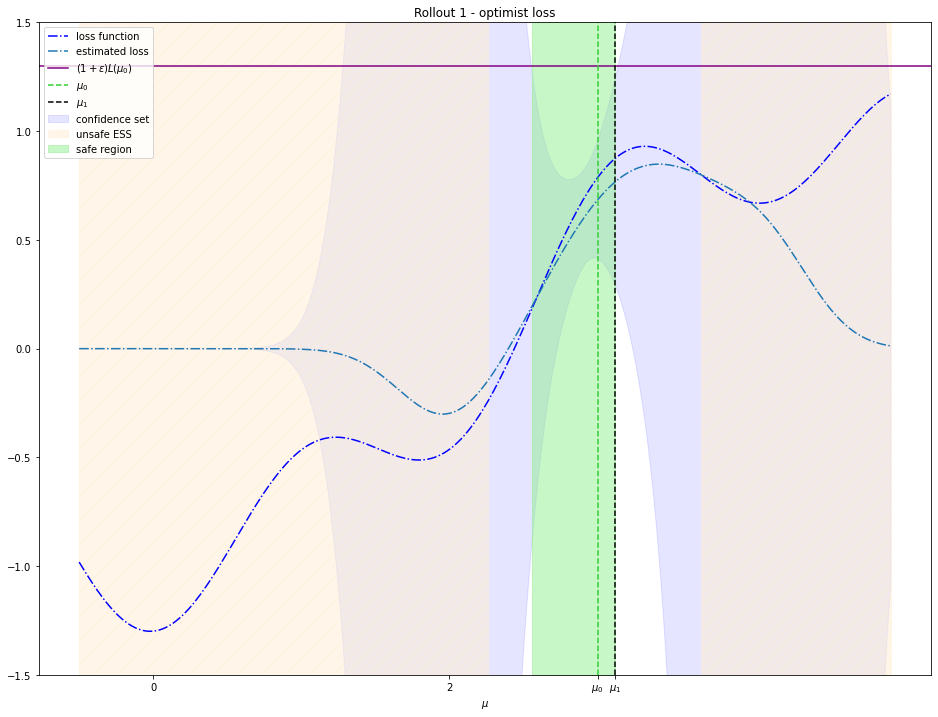

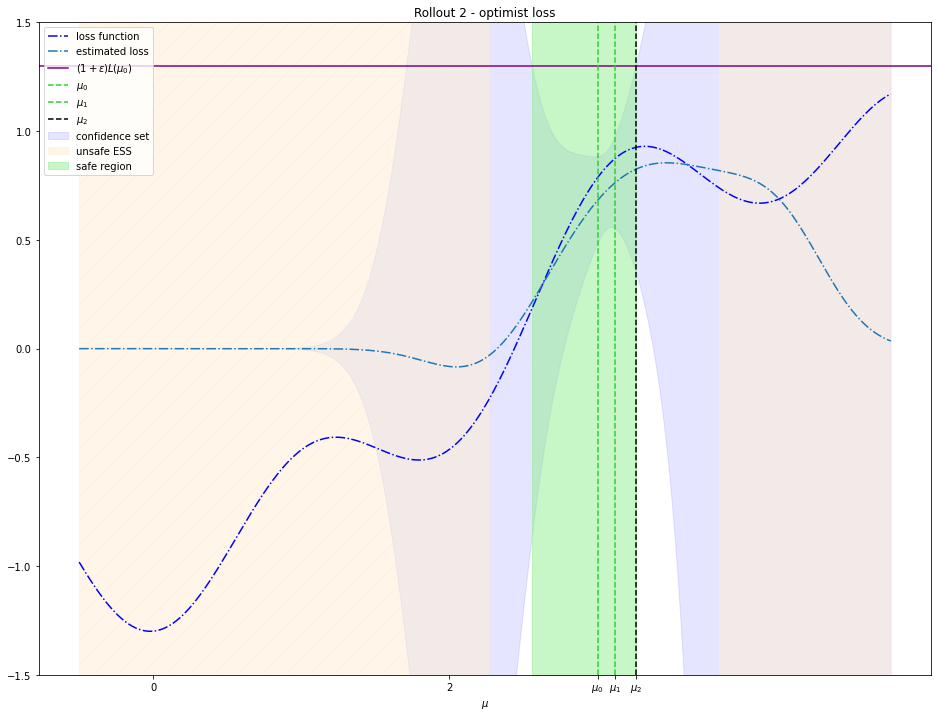

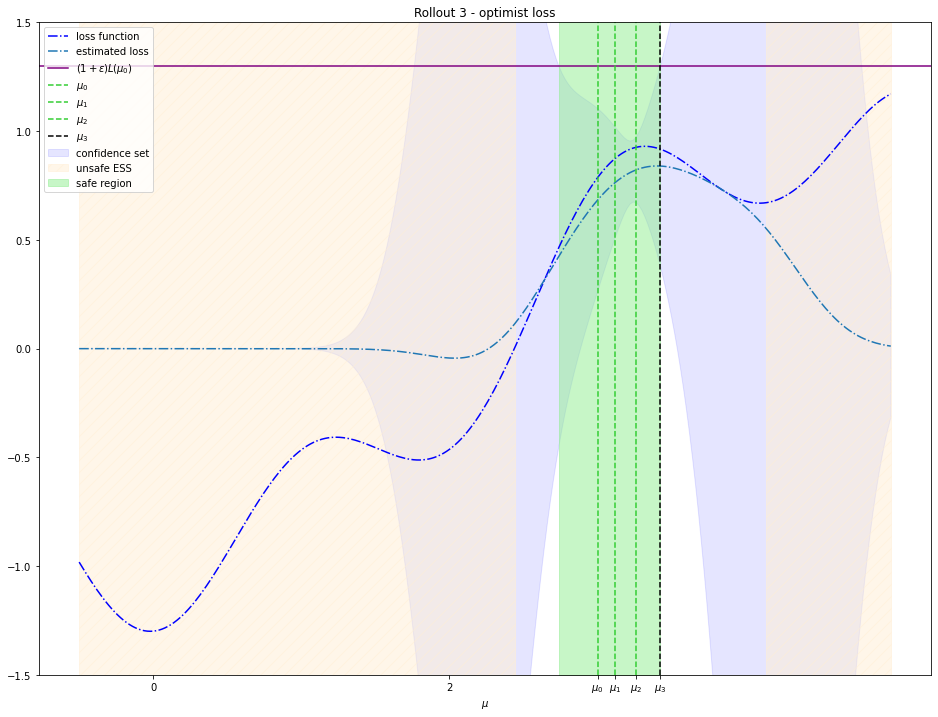

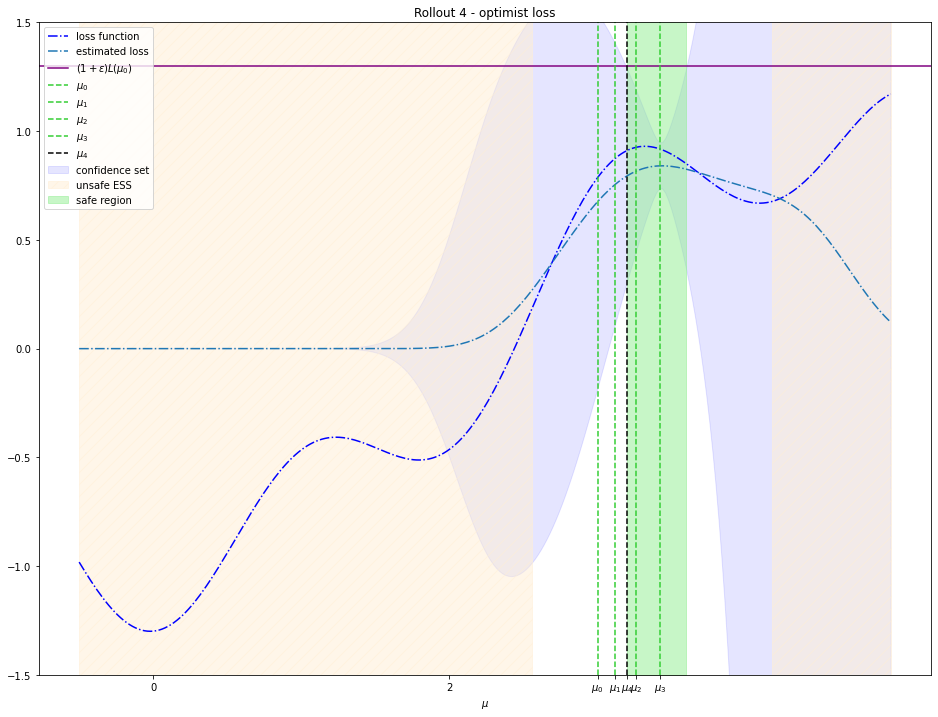

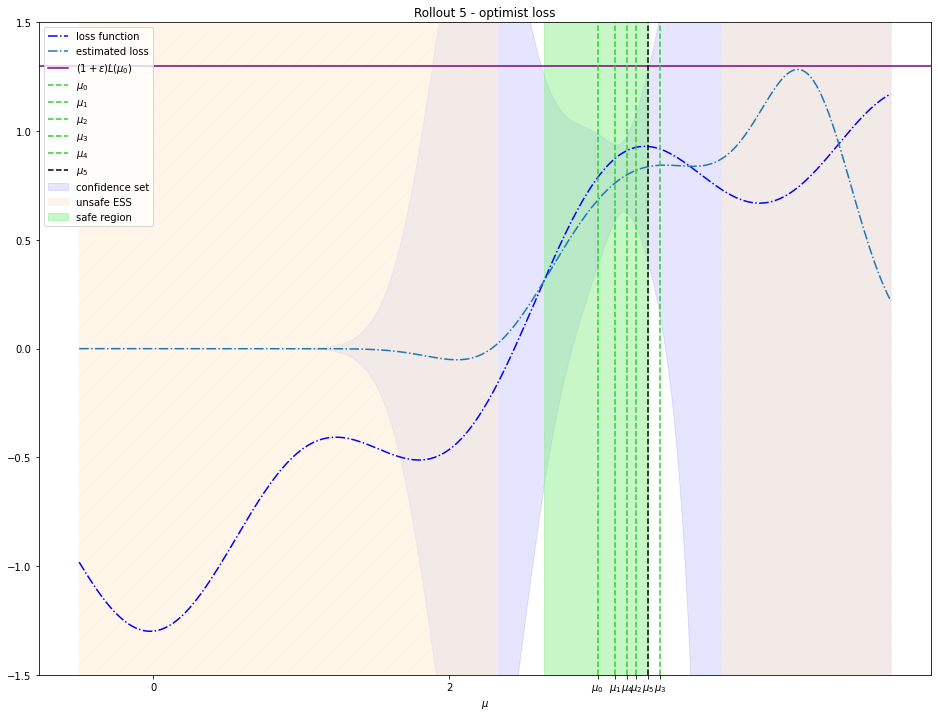

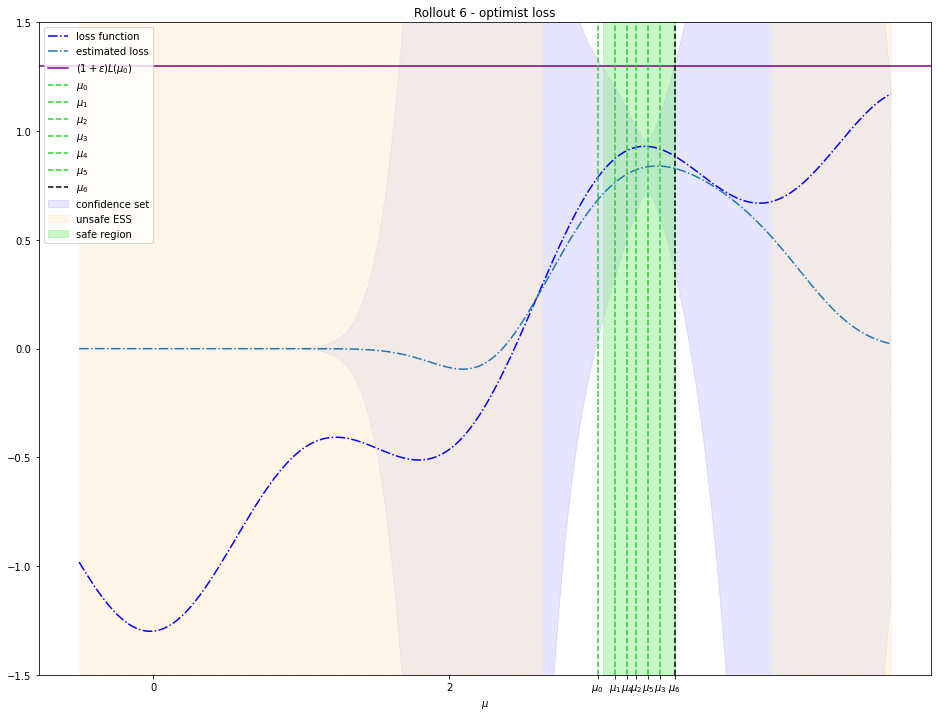

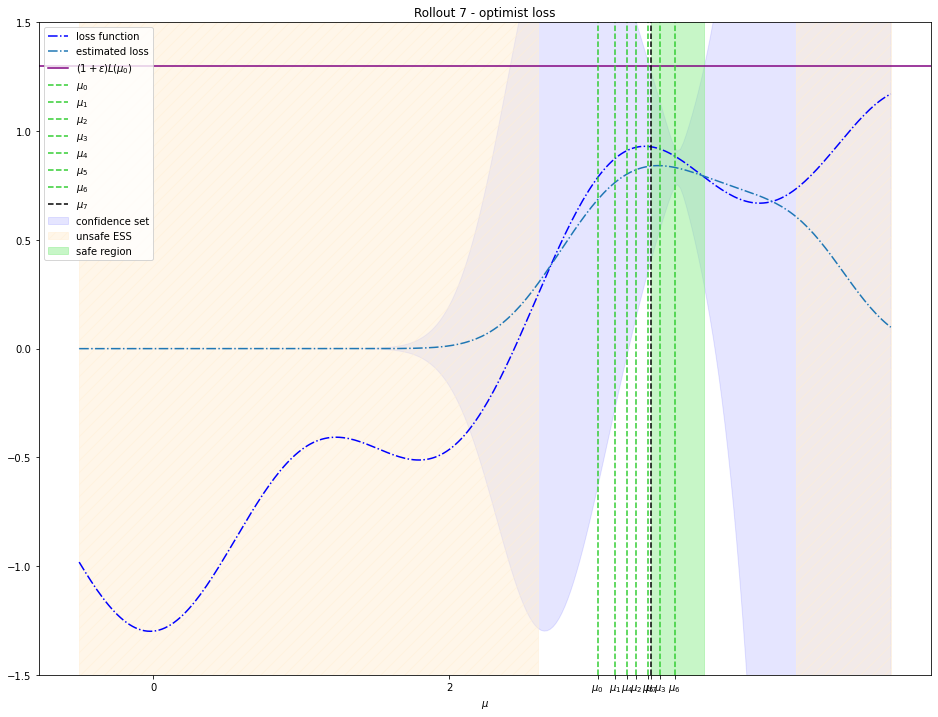

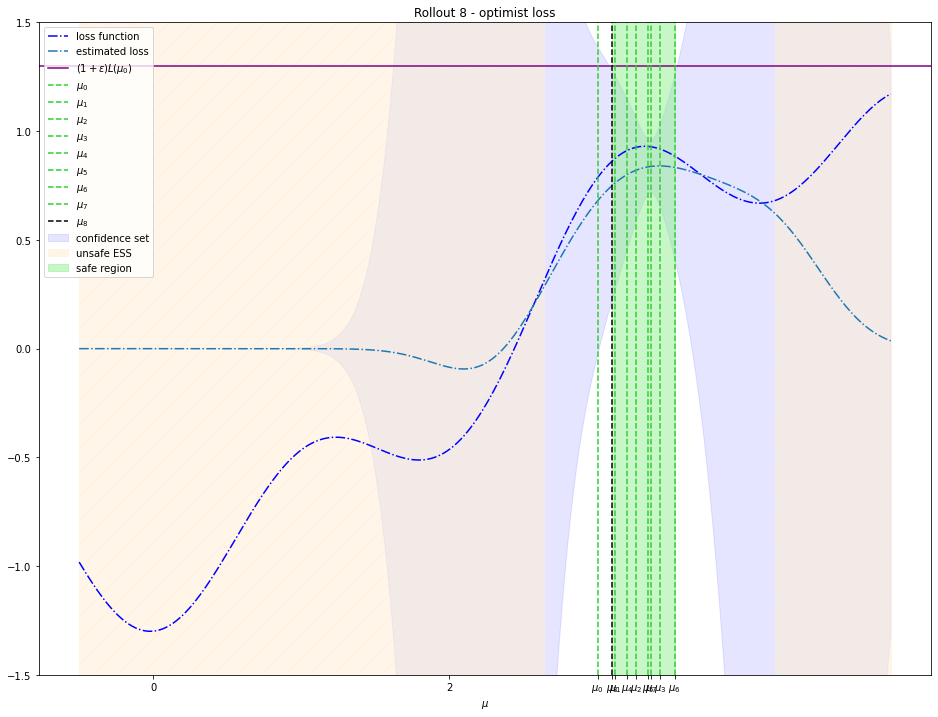

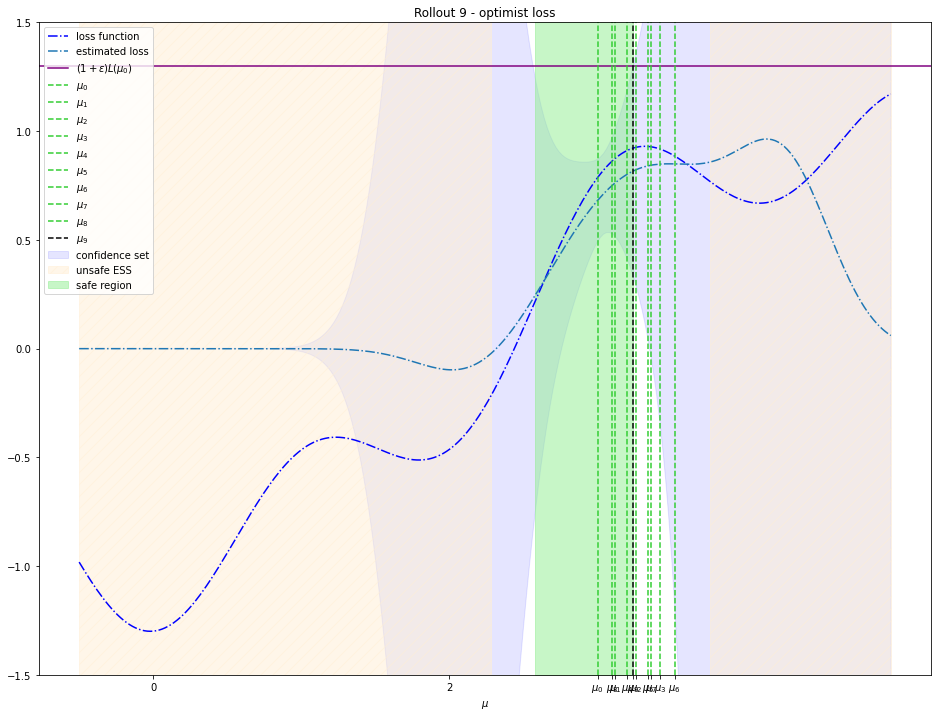

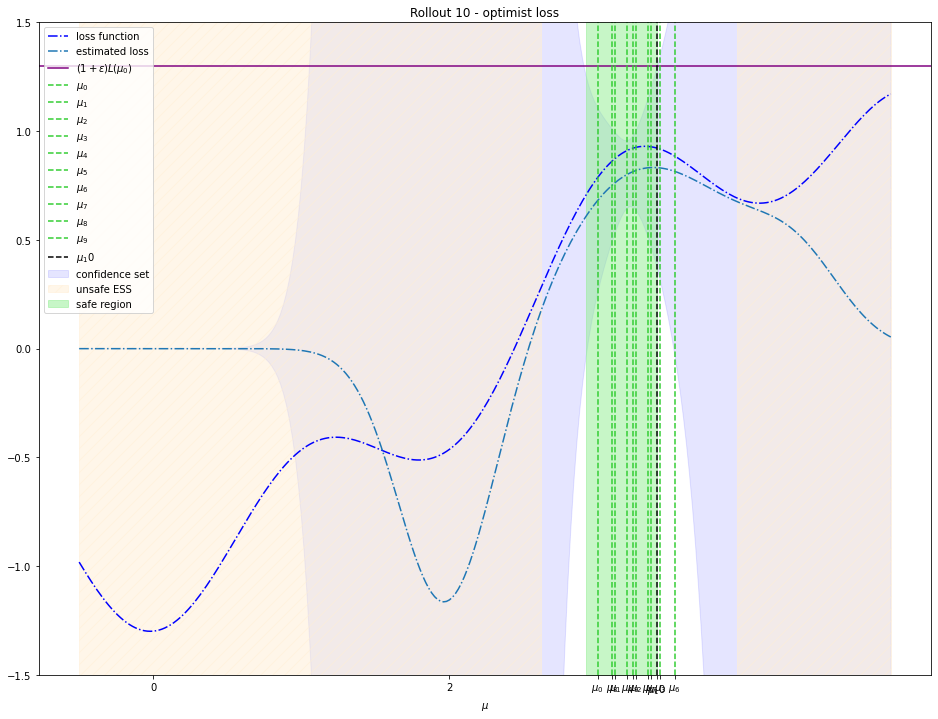

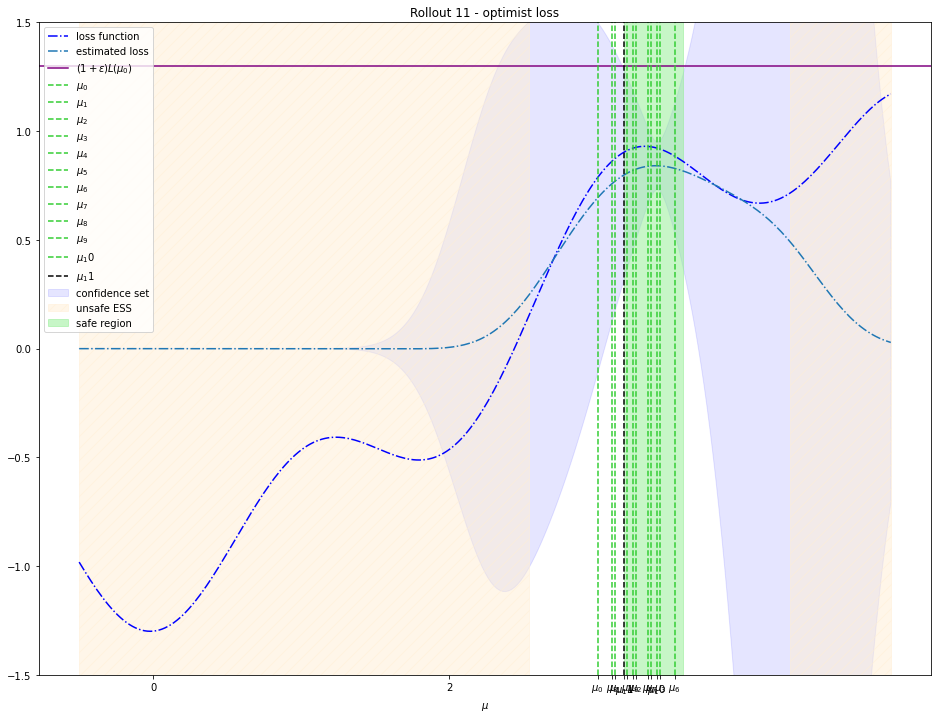

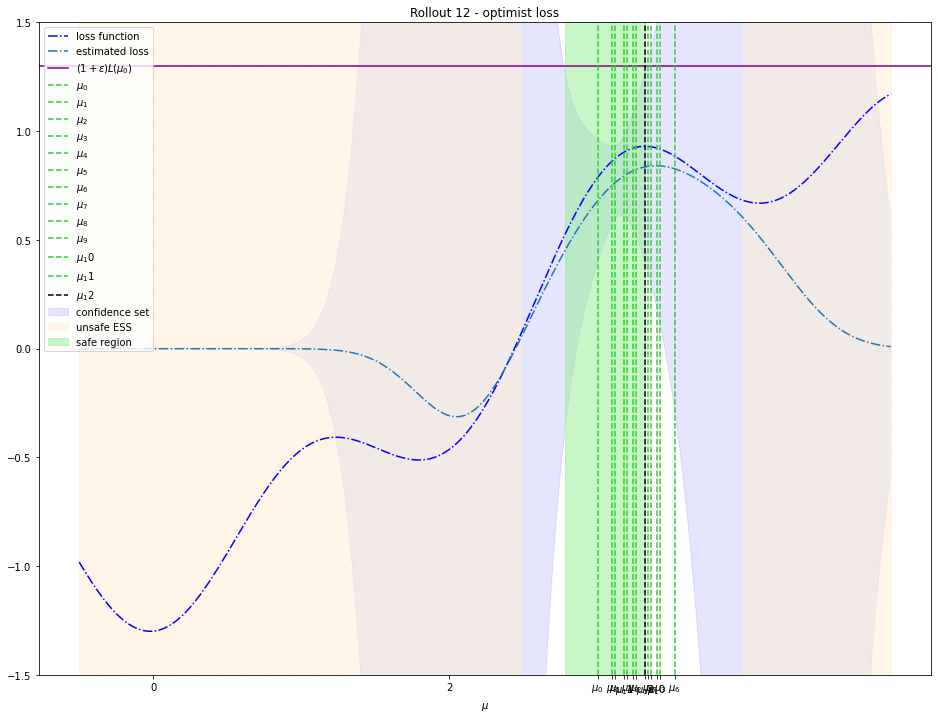

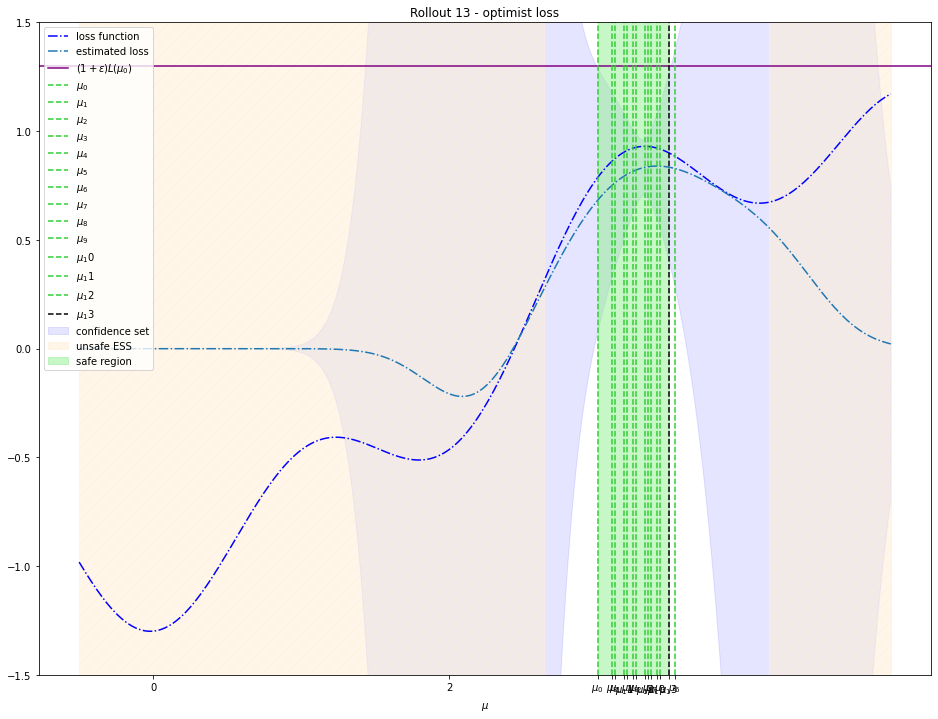

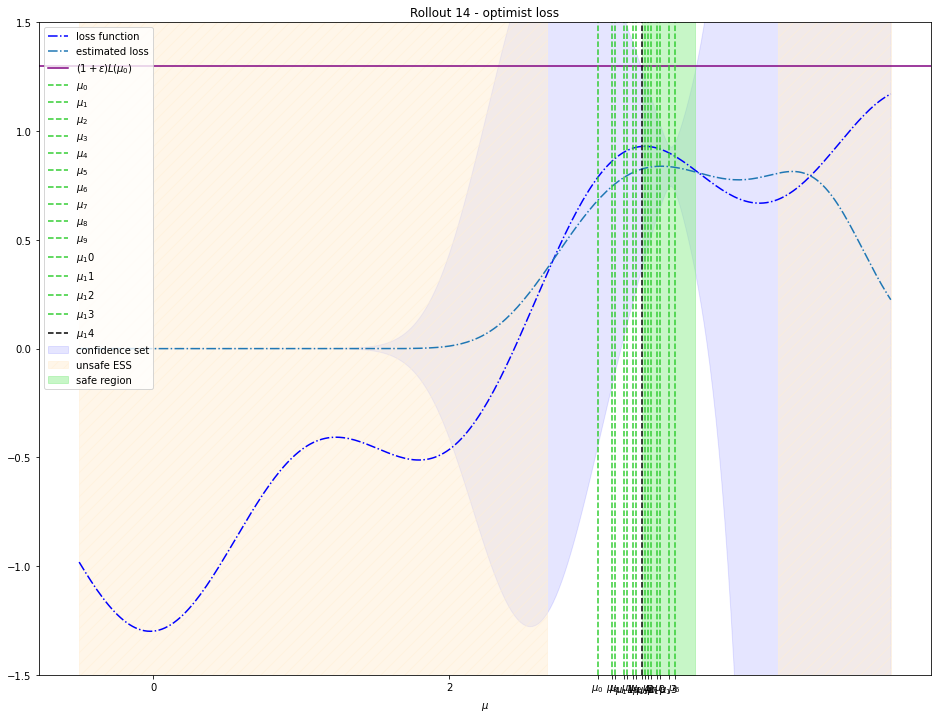

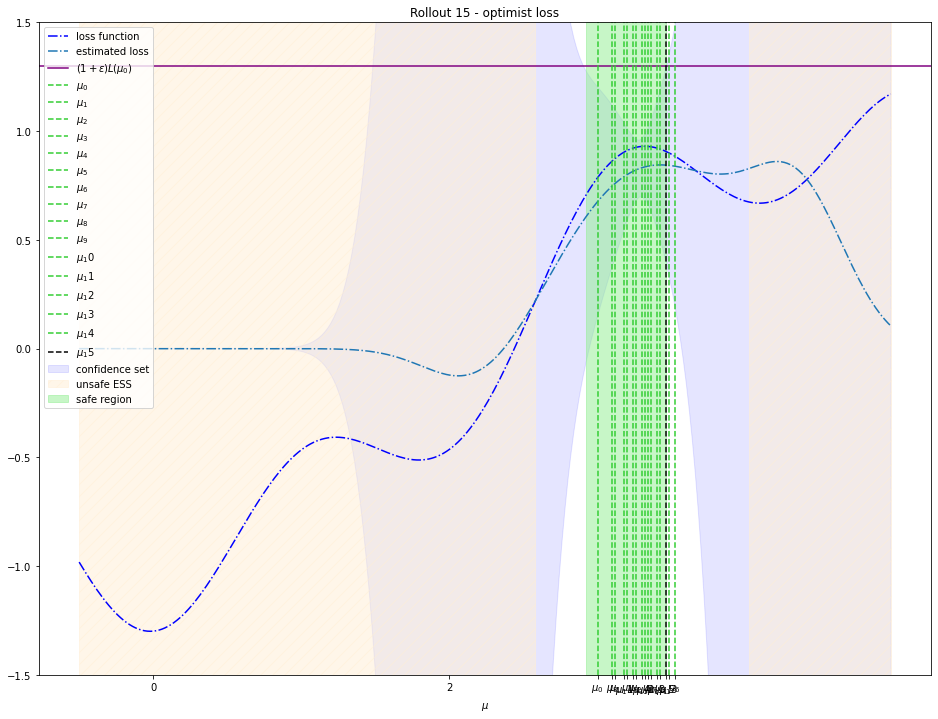

In [10]:
mode = 'optimist'
loss_fun = optimist_loss

for m in range(M):

    logging_data = logging_samples, logging_losses, logging_propensities

    def get_estimates(mu, logging_data):

        def estimates(mu, logging_data):
            logging_samples, logging_losses, logging_propensities = logging_data
            running_pdf = norm(loc=mu, scale=logging_scale).pdf
            importance_weights = running_pdf(logging_samples)/logging_pdf(logging_samples)
            ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
            return np.mean(logging_losses * importance_weights), np.std(logging_losses * importance_weights), ess_diagnostic

        estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
        estimate_means, ess_diagnostics = np.array(estimate_means), np.array(ess_diagnostics)
        upper_bounds = estimate_means+estimate_stds
        confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

        estimates = {
            'means': estimate_means,
            'stds': estimate_stds,
            'ess': ess_diagnostics,
            'confidence_region': confidence_region
        }

        return estimates

    estimates = get_estimates(mu, logging_data)
    confidence_region = estimates['confidence_region']
    init_parameter = jnp.array(mu, dtype='float32')
    args = logging_data

    optimized_mu = safe_optimize(loss_fun, init_parameter, logging_loss_threshold, confidence_region, args)
    optimized_mus.append(optimized_mu)
    plot_dynamic(estimates, optimized_mus, mode)

    ### New logging data
    mu = optimized_mu._value
    logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
    logging_losses = true_loss_function(logging_samples)
    logging_pdf = norm(loc=mu, scale=logging_scale).pdf
    logging_propensities = logging_pdf(logging_samples)

### better initialisation

In [59]:
logging_mu = 3
logging_scale = 0.3
n_samples = 10000
rng = np.random.RandomState(123)
logging_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
logging_losses = true_loss_function(logging_samples)
logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
logging_propensities = logging_pdf(logging_samples)
logging_loss = np.mean(logging_losses)
epsilon = 0.9
logging_loss_threshold = logging_loss*(1+epsilon)
logging_data = logging_samples, logging_losses, logging_propensities

mu = logging_mu - 0.1
optimized_mus = [mu]
M = 15

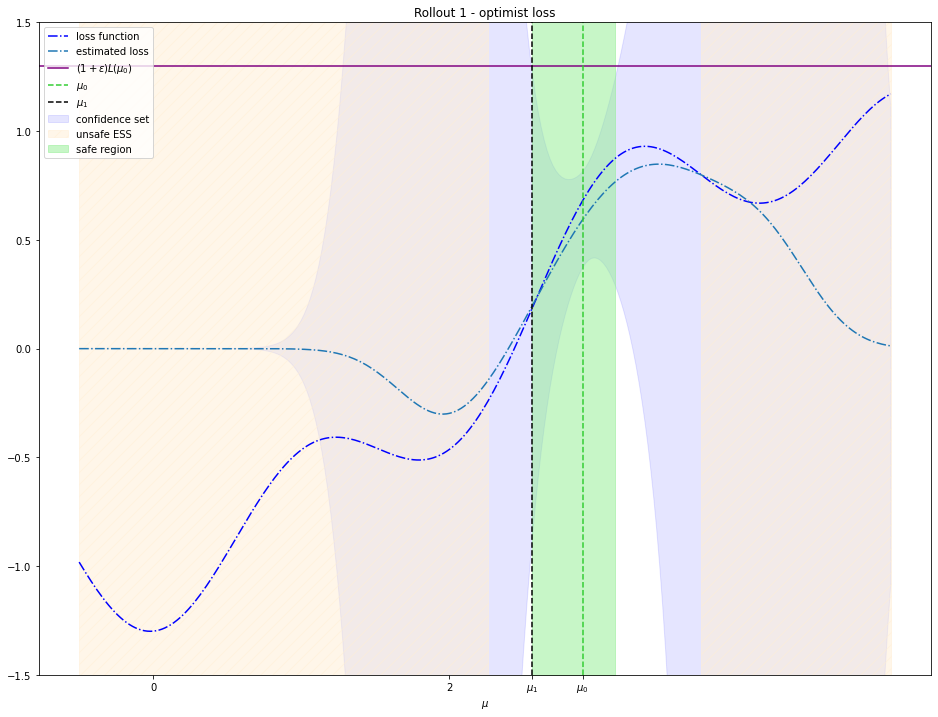

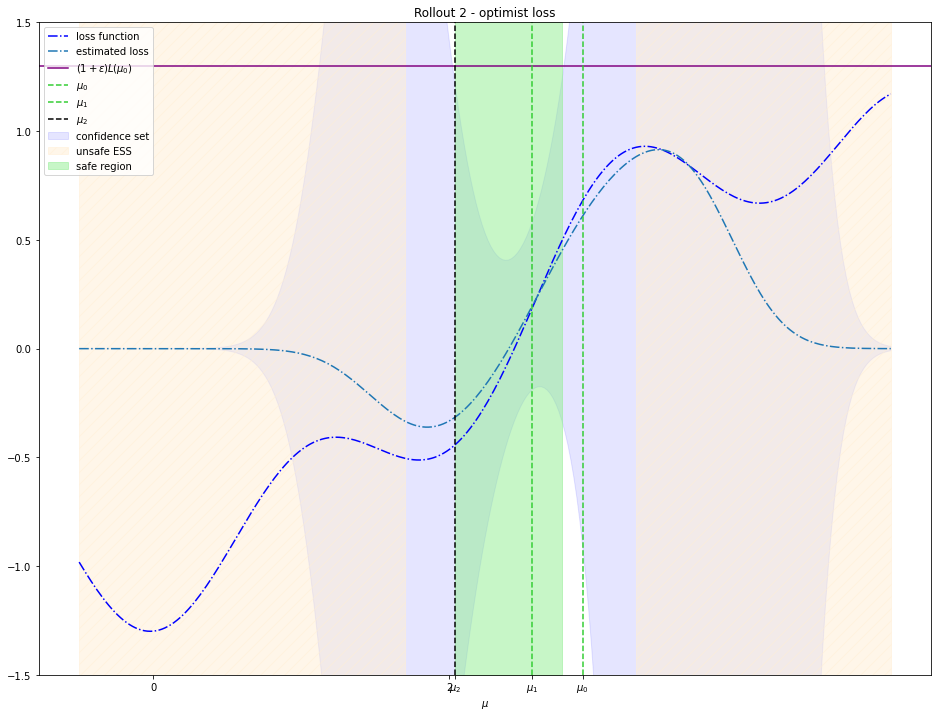

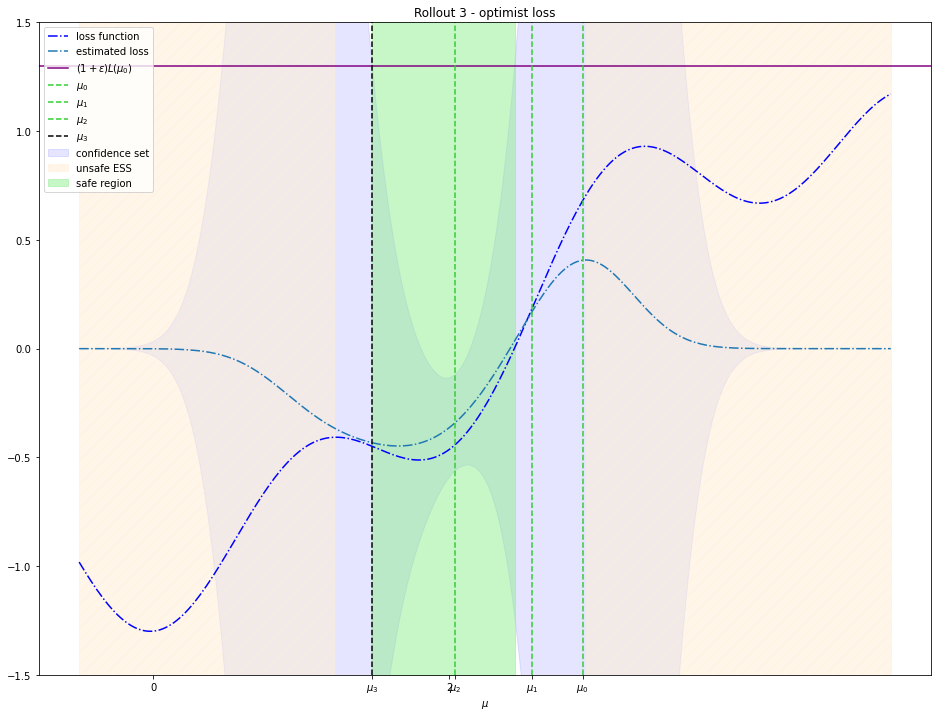

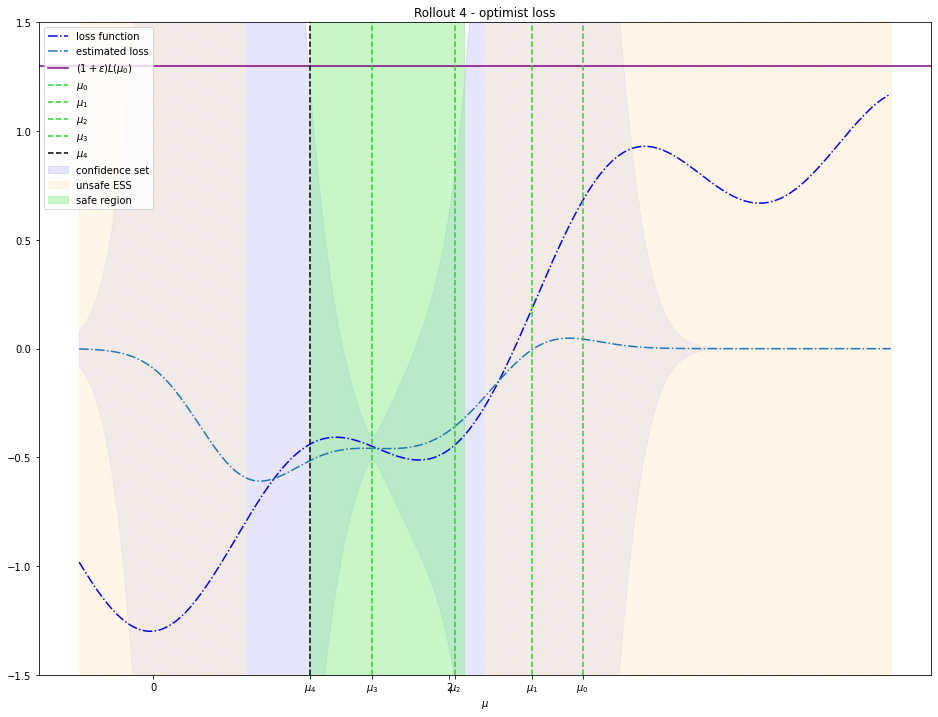

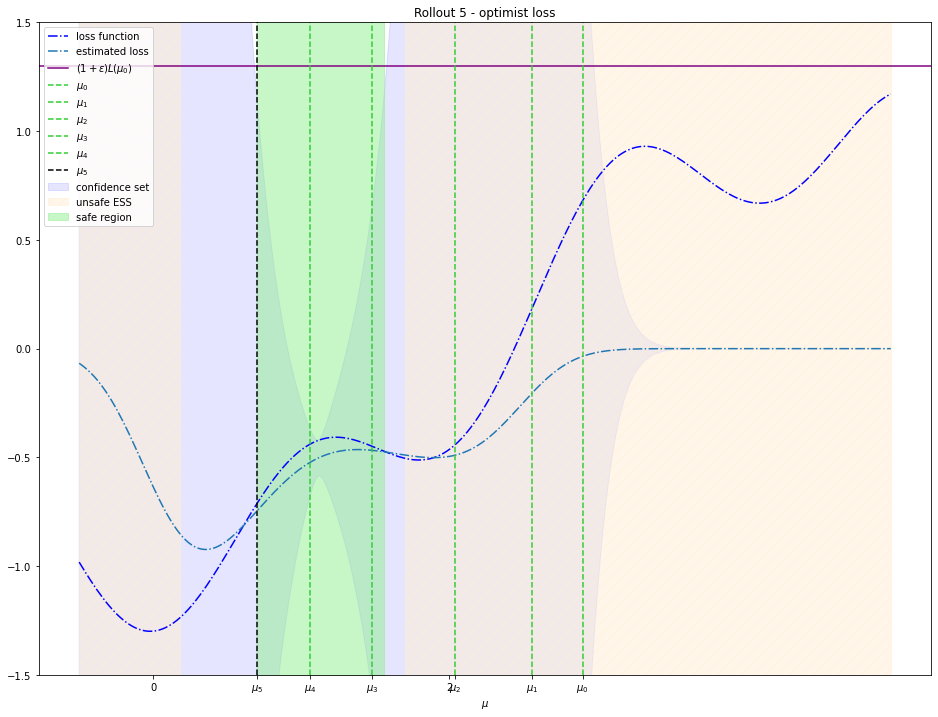

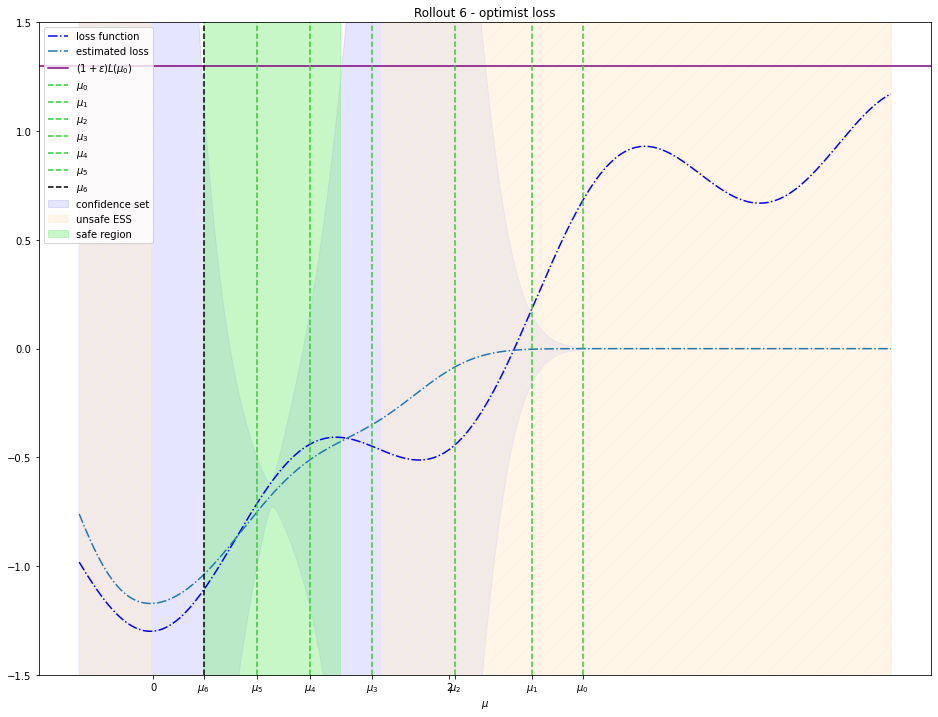

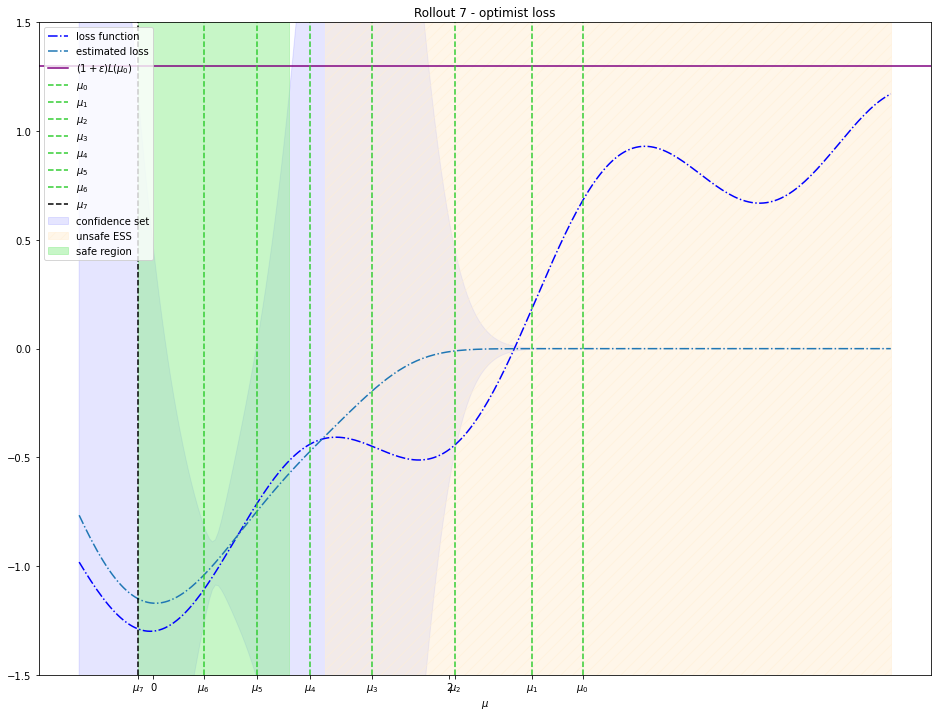

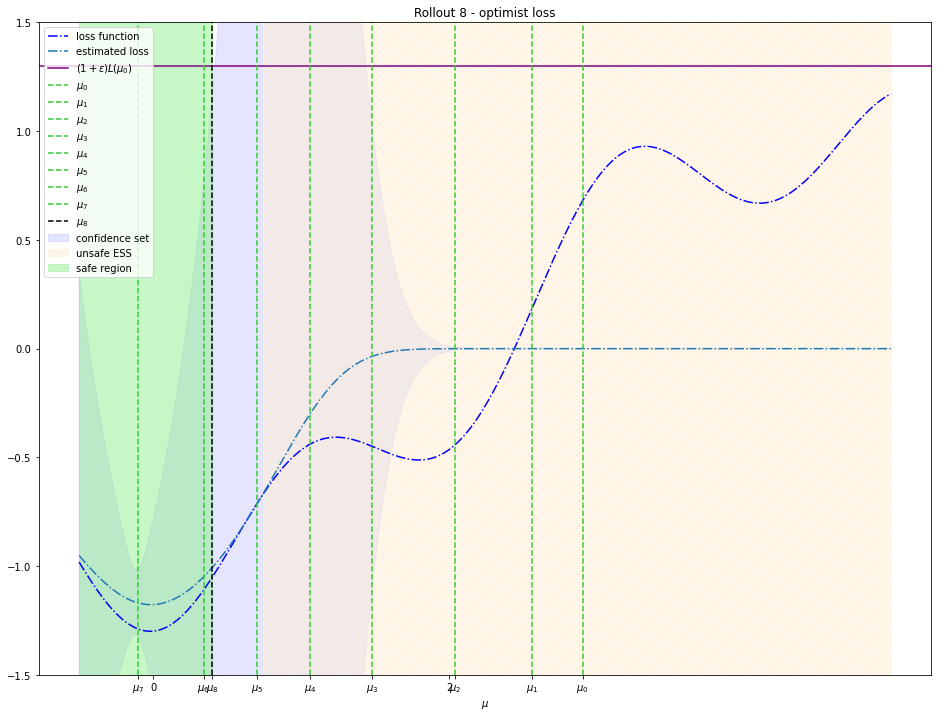

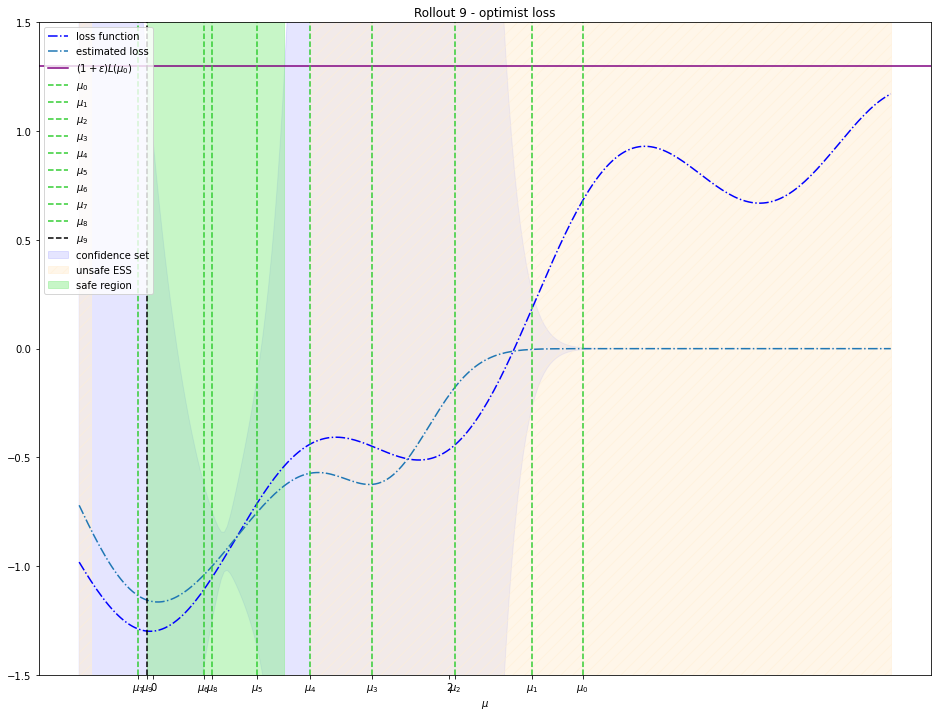

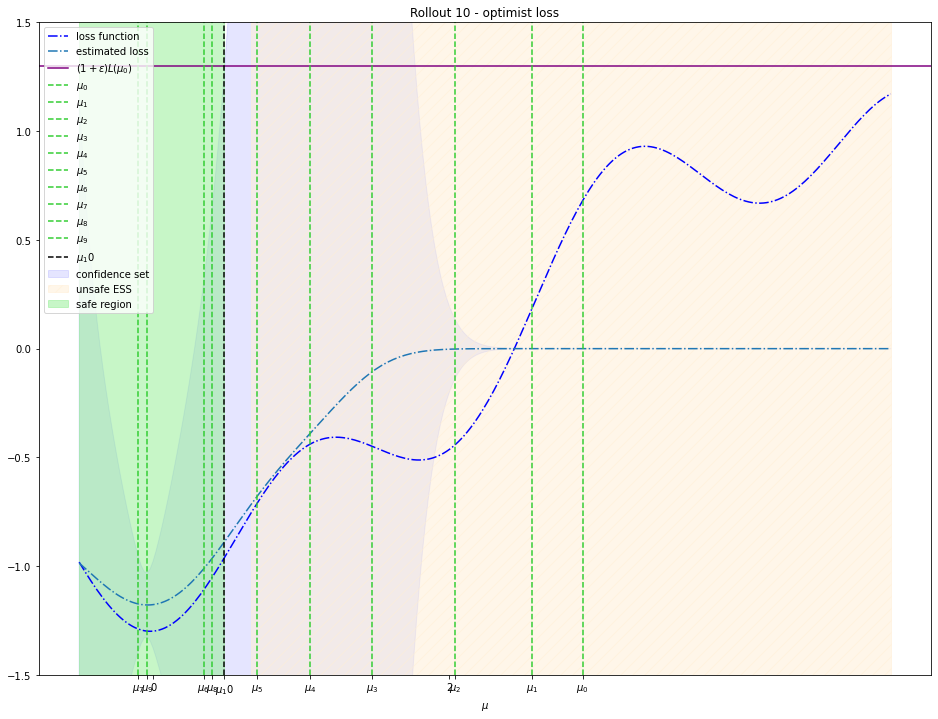

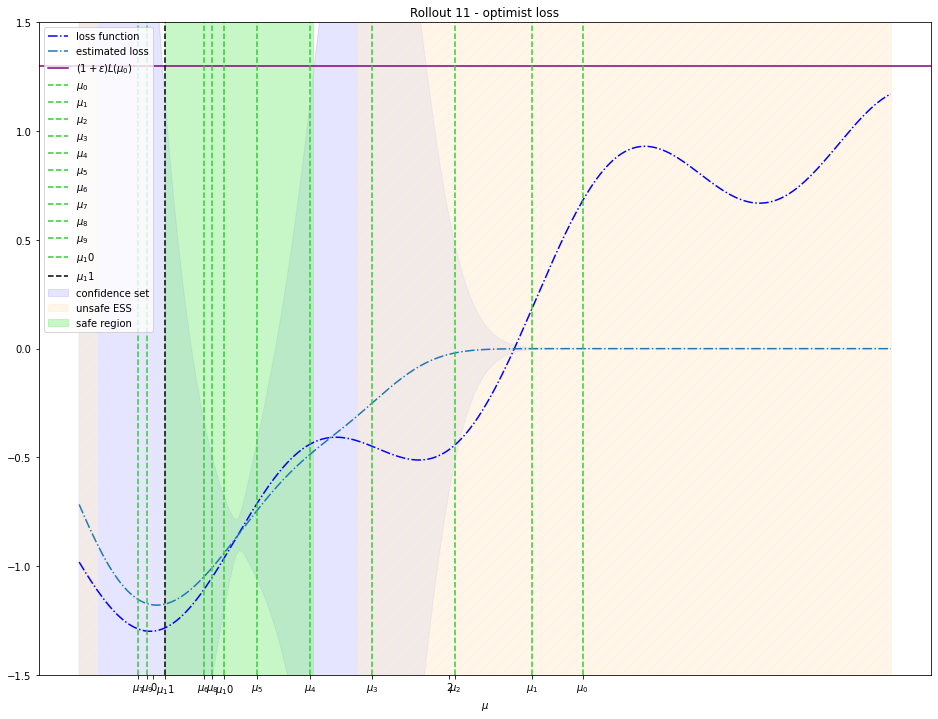

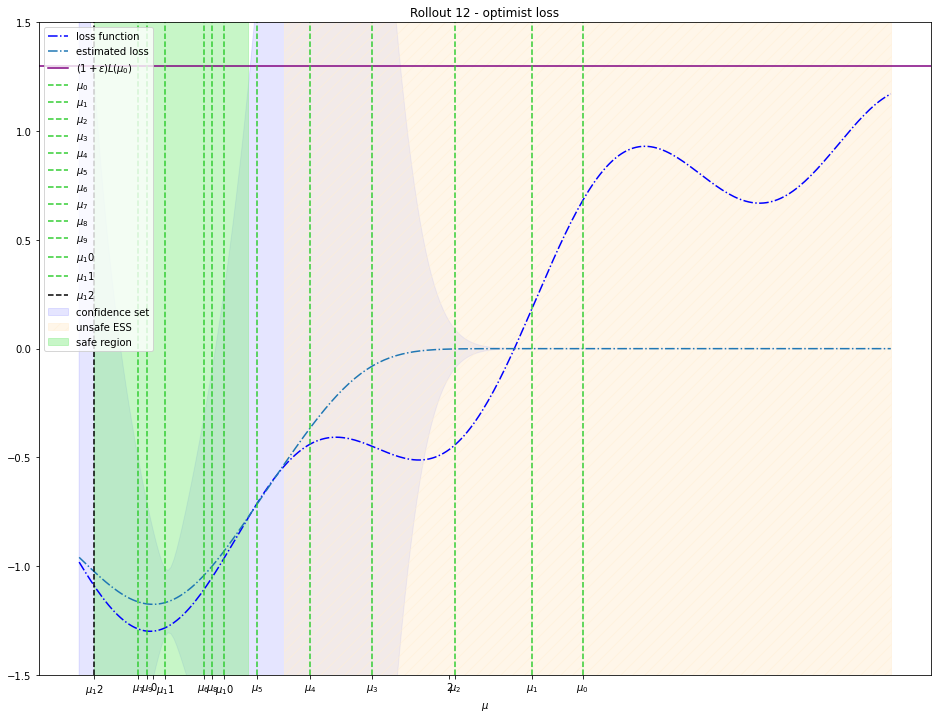

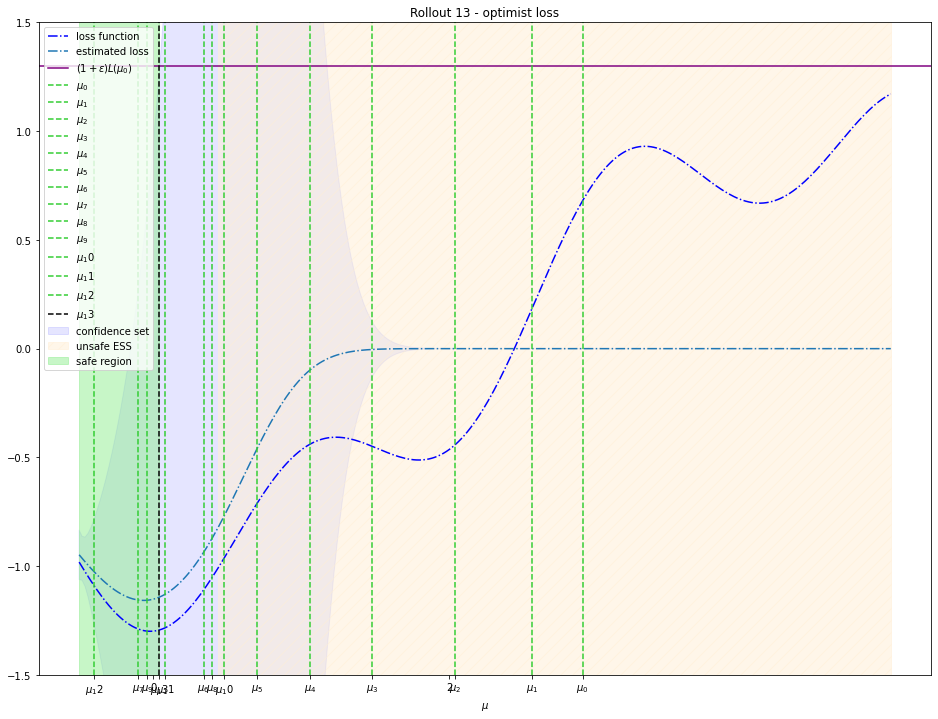

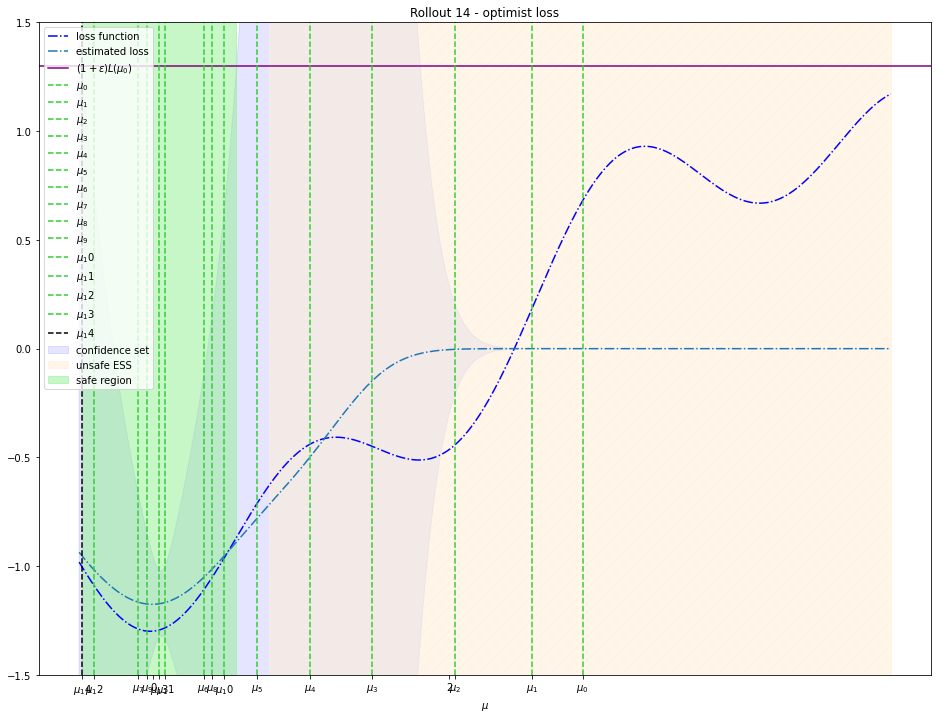

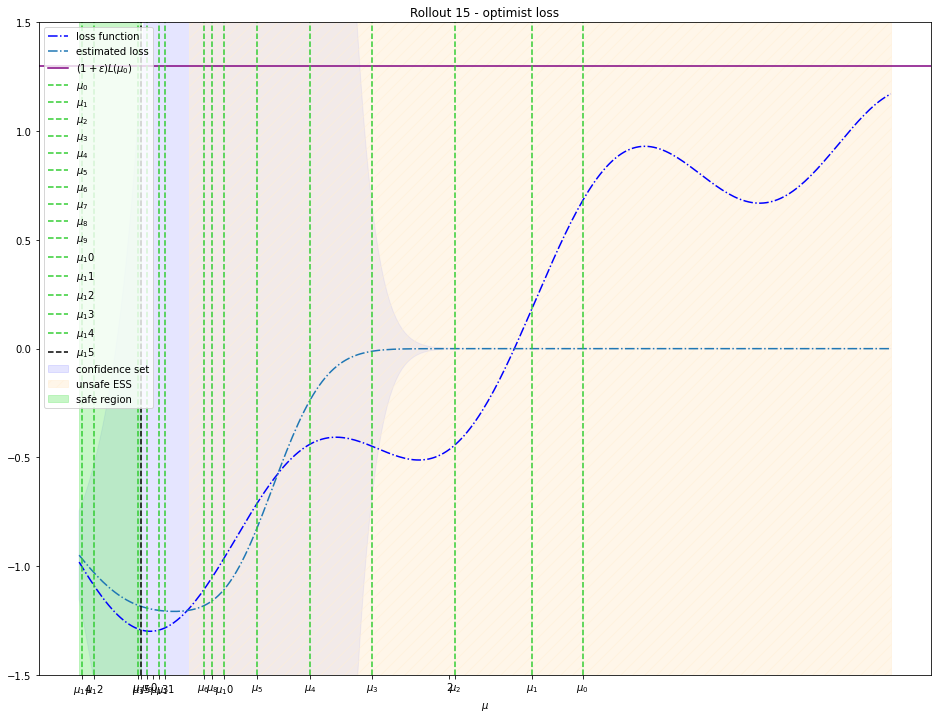

In [12]:
mode = 'optimist'
loss_fun = optimist_loss

for m in range(M):

    logging_data = logging_samples, logging_losses, logging_propensities

    def get_estimates(mu, logging_data):

        def estimates(mu, logging_data):
            logging_samples, logging_losses, logging_propensities = logging_data
            running_pdf = norm(loc=mu, scale=logging_scale).pdf
            importance_weights = running_pdf(logging_samples)/logging_pdf(logging_samples)
            ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/n_samples
            return np.mean(logging_losses * importance_weights), np.std(logging_losses * importance_weights), ess_diagnostic

        estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
        estimate_means, ess_diagnostics = np.array(estimate_means), np.array(ess_diagnostics)
        upper_bounds = estimate_means+estimate_stds
        confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

        estimates = {
            'means': estimate_means,
            'stds': estimate_stds,
            'ess': ess_diagnostics,
            'confidence_region': confidence_region
        }

        return estimates

    estimates = get_estimates(mu, logging_data)
    confidence_region = estimates['confidence_region']
    init_parameter = jnp.array(mu, dtype='float32')
    args = logging_data

    optimized_mu = safe_optimize(loss_fun, init_parameter, logging_loss_threshold, confidence_region, args)
    optimized_mus.append(optimized_mu)
    plot_dynamic(estimates, optimized_mus, mode)

    ### New logging data
    mu = optimized_mu._value
    logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
    logging_losses = true_loss_function(logging_samples)
    logging_pdf = norm(loc=mu, scale=logging_scale).pdf
    logging_propensities = logging_pdf(logging_samples)

In [68]:
n_samples = np.array([[100], [200], [1000]])
actions = np.array([np.random.uniform(2,3, size=(100)), np.random.uniform(2,3, size=(200)), np.random.uniform(2,3, size=(1000))], dtype=object)
# mus = [3.2, 2.5, 2.2]
losses = np.array([np.random.uniform(size=(100)), np.random.uniform(size=(200)), np.random.uniform(size=(1000))], dtype=object)
losses.shape
logging_scale = 0.3
distributions = [norm(loc=mu, scale=logging_scale).pdf for mu in mus]
logging_propensities = np.array([distribution(action_samples) for distribution, action_samples in zip(distributions, actions)], dtype=object)

In [73]:
actions
samples = np.random.uniform(size=2000)
actions = np.array(actions.tolist() + [samples])

ValueError: all input arrays must have the same shape

In [84]:
np.concatenate([n_samples, [[4]]], axis=0)

array([[ 100],
       [ 200],
       [1000],
       [   4]])

In [76]:
actions.tolist() + [samples]

[array([2.61569398, 2.95306332, 2.13555458, 2.31892405, 2.48430364,
        2.88887105, 2.09736874, 2.07826435, 2.99085898, 2.31794884,
        2.91778529, 2.38164368, 2.28845549, 2.23700166, 2.37013683,
        2.81533361, 2.47074415, 2.22720923, 2.87698042, 2.76314451,
        2.15775226, 2.95014714, 2.42292342, 2.29735231, 2.54496448,
        2.62552355, 2.6388394 , 2.39629332, 2.13972248, 2.6620386 ,
        2.34788586, 2.52243097, 2.84694791, 2.00737179, 2.86543991,
        2.61278261, 2.02880298, 2.02804785, 2.34028342, 2.69499557,
        2.48286677, 2.4160147 , 2.48865585, 2.86153412, 2.19945922,
        2.82003981, 2.49430249, 2.49767358, 2.48458473, 2.50745494,
        2.23062944, 2.09740251, 2.34132784, 2.36305423, 2.70546883,
        2.81262955, 2.31825755, 2.4558774 , 2.17754472, 2.13504955,
        2.1570198 , 2.89594235, 2.85112784, 2.39607442, 2.9691768 ,
        2.70340097, 2.90744959, 2.9469379 , 2.73383279, 2.50325625,
        2.23251562, 2.5288239 , 2.23161527, 2.30

In [12]:
def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

### Utilities

def get_all_data(logging_samples, logging_losses, logging_propensities):
    all_logging_samples = np.concatenate(logging_samples)
    all_losses = np.concatenate(logging_losses)
    all_logging_propensities = np.concatenate(logging_propensities)
    return all_logging_samples, all_losses, all_logging_propensities


### Multiple IPS

def get_omega_weights(params, all_actions, all_propensities):
    distributions = [norm(loc=param, scale=logging_scale).pdf for param in params]
    pi_t = np.array([distribution(all_actions) for distribution in distributions])
    n_pi_t = n_samples * pi_t
    sum_n_pi_t = np.sum(n_pi_t, axis=0)
    all_omegas = all_propensities / sum_n_pi_t
    return all_omegas

def multi_ips_mean(param, all_logging_samples, all_losses, all_logging_propensities, all_omegas):
    # Importance weights
    all_importance_weights = pdf(param, all_logging_samples)/all_logging_propensities
    
    # Omega weight
    return np.sum(all_omegas * all_losses * all_importance_weights)


### Mixture IPS

def get_mixture_logging_propensities(params, n_samples, all_policy_samples):
    distributions = [norm(loc=param, scale=logging_scale).pdf for param in params]
    pi_t = np.array([distribution(all_policy_samples) for distribution in distributions])
    alpha_t = n_samples/ np.sum(n_samples)
    mixture_logging_propensities = np.sum(alpha_t * pi_t, axis=0)
    return mixture_logging_propensities

def conservative_mixture_loss(param, logging_samples, logging_losses, mixture_logging_propensities):
    mixture_importance_weights = pdf(param, logging_samples)/mixture_logging_propensities
#     import ipdb; ipdb.set_trace()
    mixture_ips_mean = jnp.mean(logging_losses * mixture_importance_weights)
#     import ipdb; ipdb.set_trace()
    mixture_ips_std = jnp.sqrt(jnp.sum(jnp.cov(logging_losses * mixture_importance_weights)))
    
    return mixture_ips_mean + mixture_ips_std
    
def optimist_mixture_loss(param, logging_samples, logging_losses, mixture_logging_propensities):
    mixture_importance_weights = pdf(param, logging_samples)/mixture_logging_propensities
    mixture_ips_mean = jnp.mean(logging_losses * mixture_importance_weights)
    mixture_ips_std = jnp.sqrt(jnp.sum(jnp.cov(logging_losses * mixture_importance_weights)))
    return mixture_ips_mean - mixture_ips_std


## Sequential with past information

In [23]:
logging_mu = 3
logging_scale = 0.3
number_samples = 10
rng = np.random.RandomState(123)
logging_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=number_samples)
logging_losses = np.array([true_loss_function(logging_samples)])
logging_samples = np.array([logging_samples])
logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
logging_propensities = np.array([np.array(logging_pdf(logging_samples)).squeeze()])
logging_loss = np.mean(np.concatenate(logging_losses))
epsilon = 0.9
logging_loss_threshold = logging_loss*(1+epsilon)
logging_data = logging_samples, logging_losses, logging_propensities

mus = np.arange(-0.5, 5., 0.02)
mu = logging_mu - 0.1
optimized_mus = [mu]
M = 15
n_samples = np.array([[number_samples]])

In [24]:
logging_propensities

array([[0.73766711, 0.80871016, 1.27761602, 0.42765965, 1.12484488,
        0.3400757 , 0.06999358, 1.21294495, 0.59674641, 0.91339652]])

In [25]:
def update_past_data(data, samples):
    return np.array(data.tolist() + [samples])

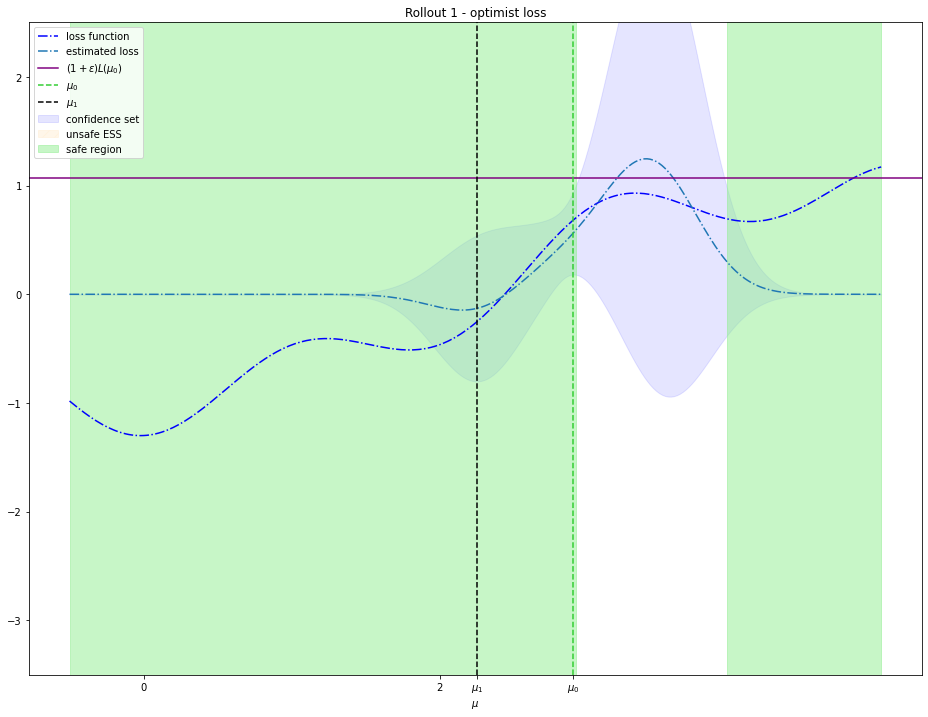

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


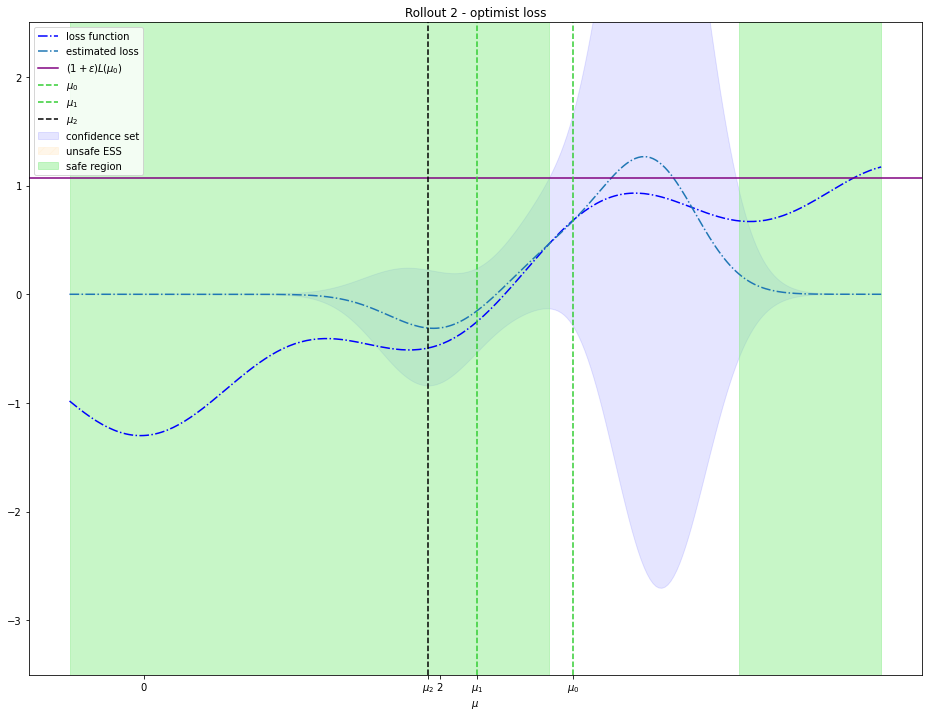

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


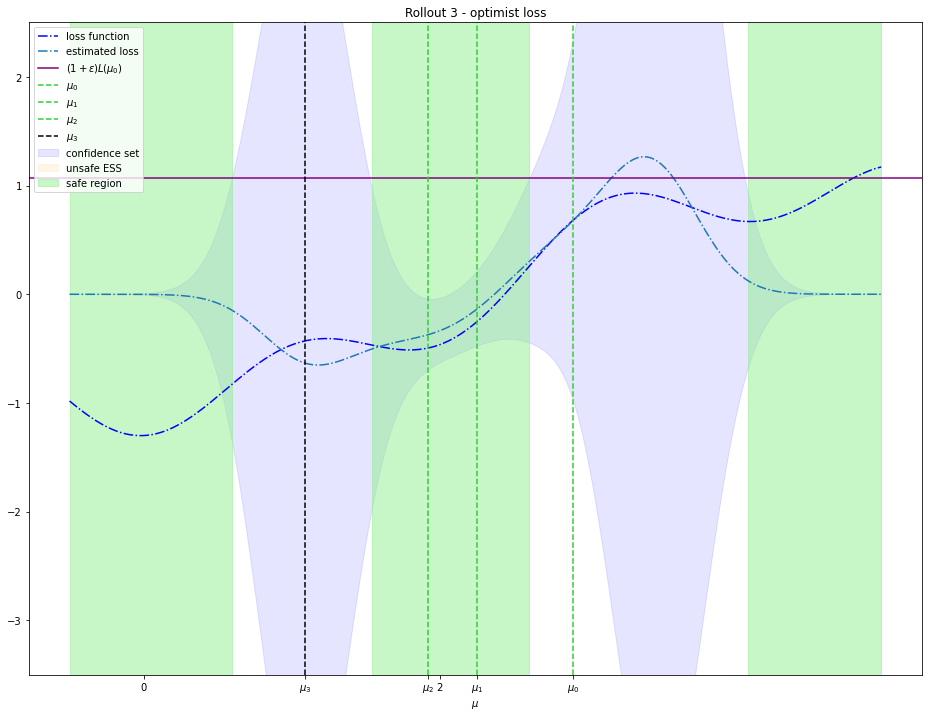

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


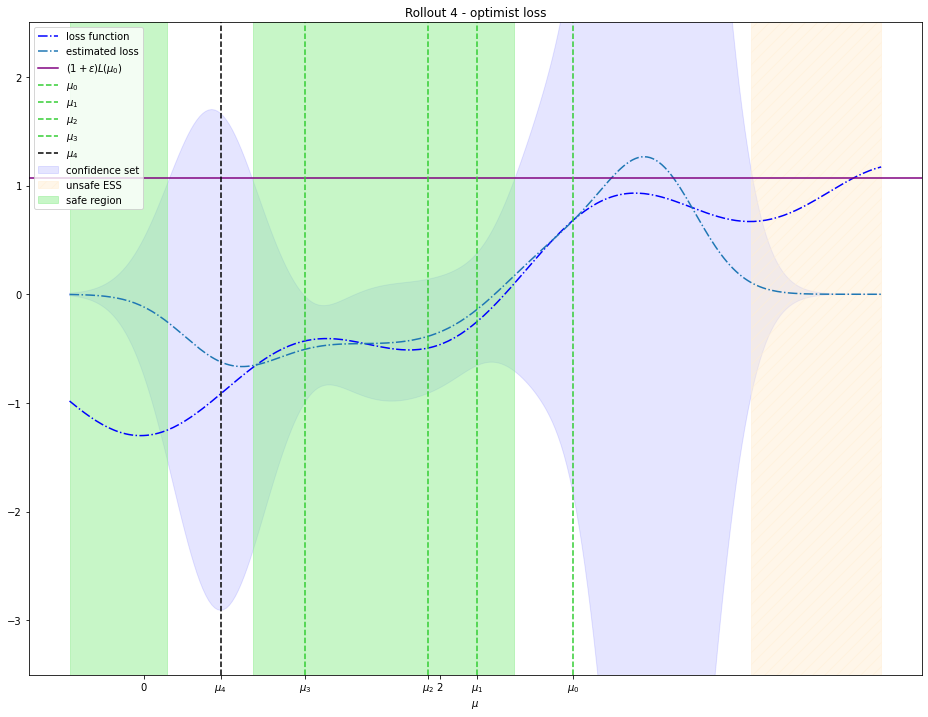

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


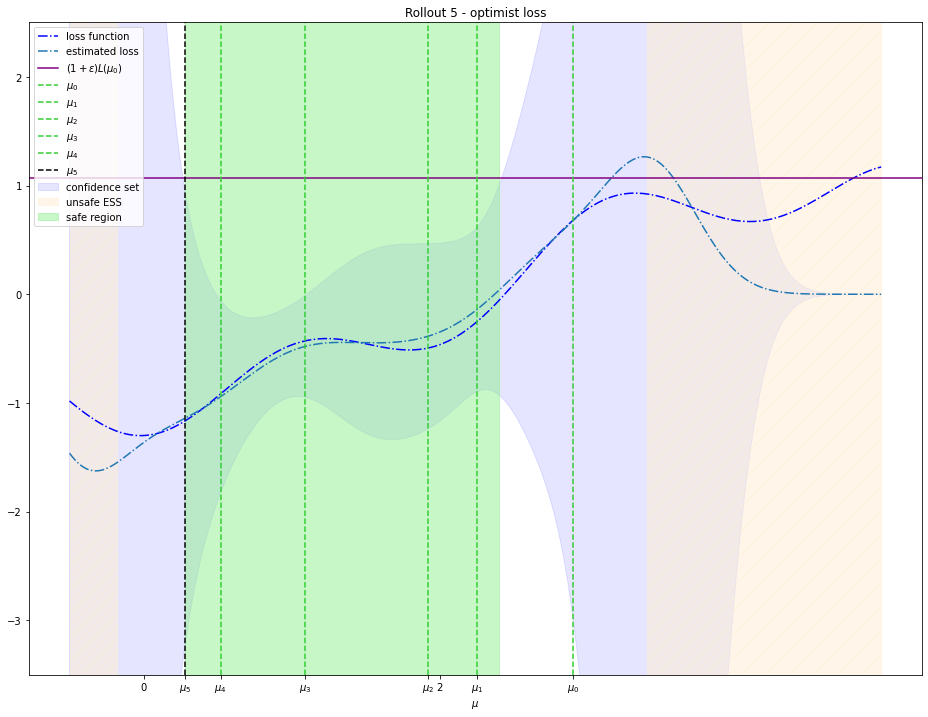

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


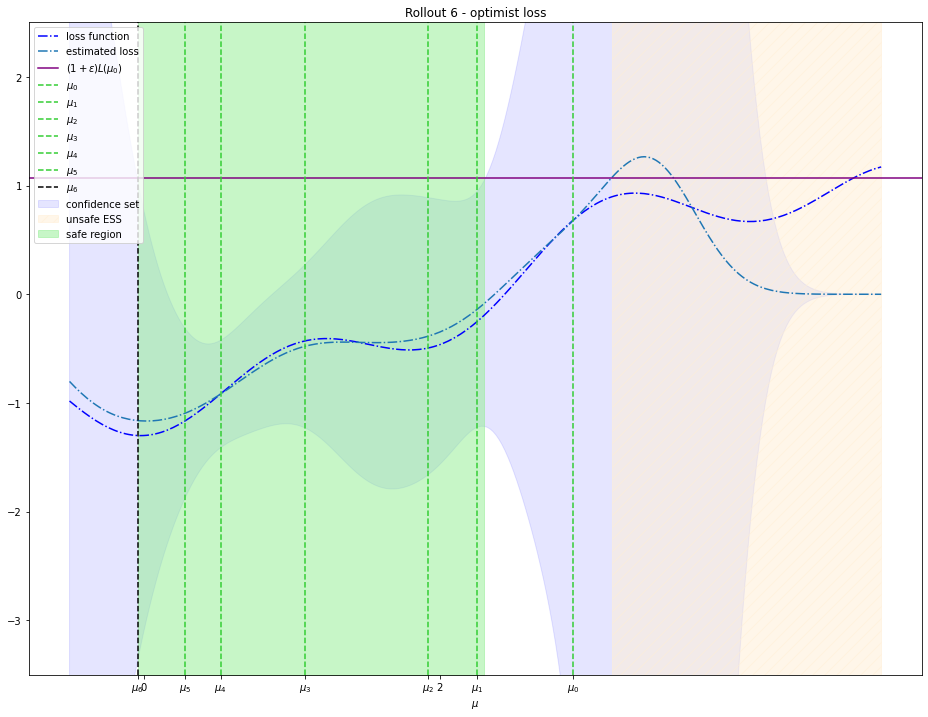

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


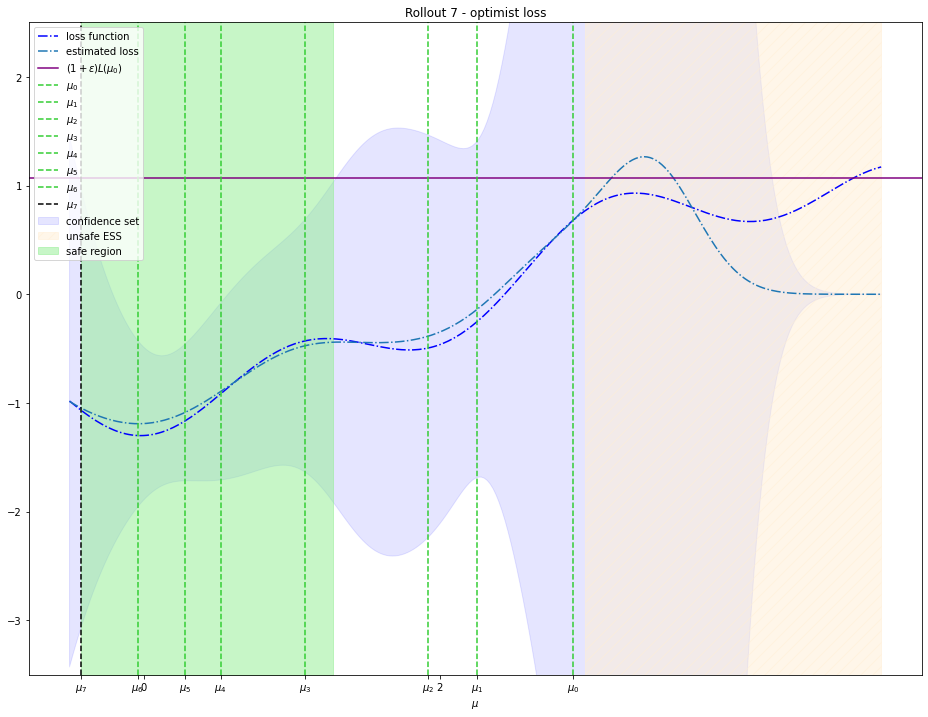

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


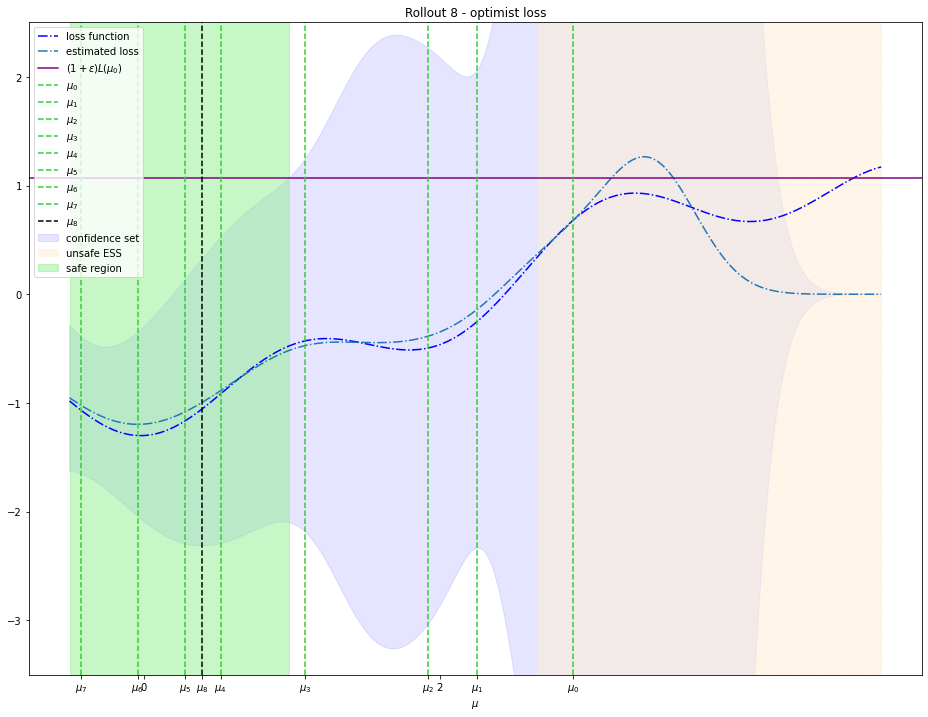

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


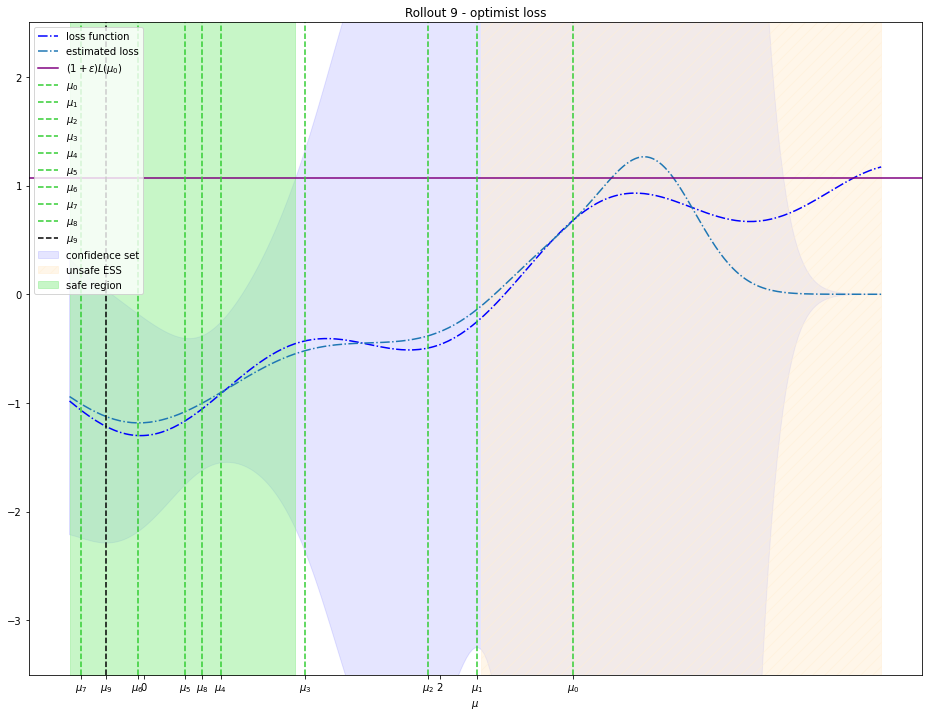

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


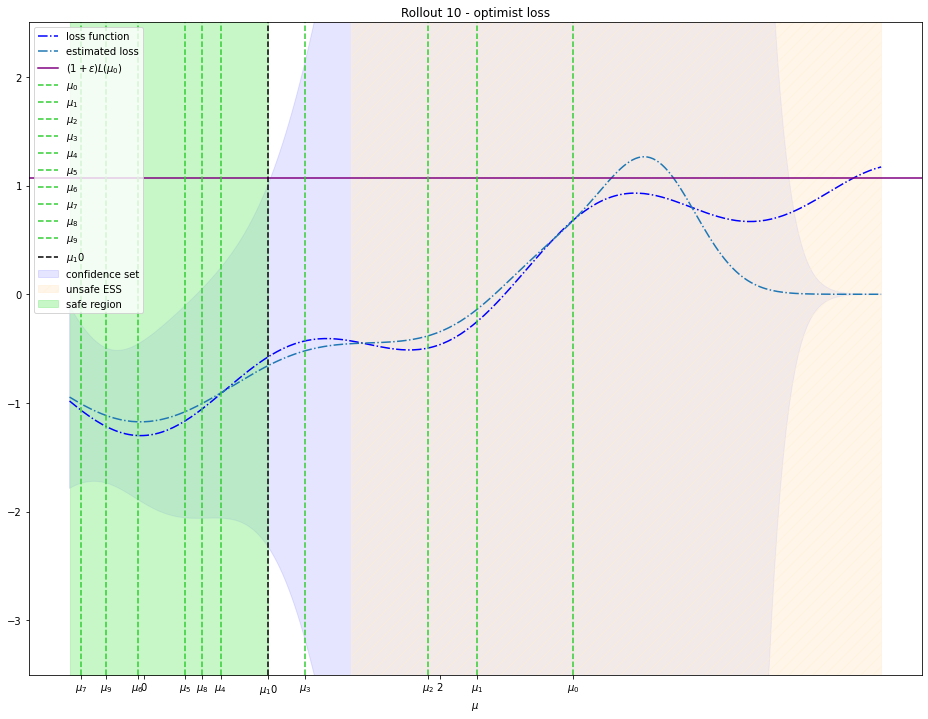

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


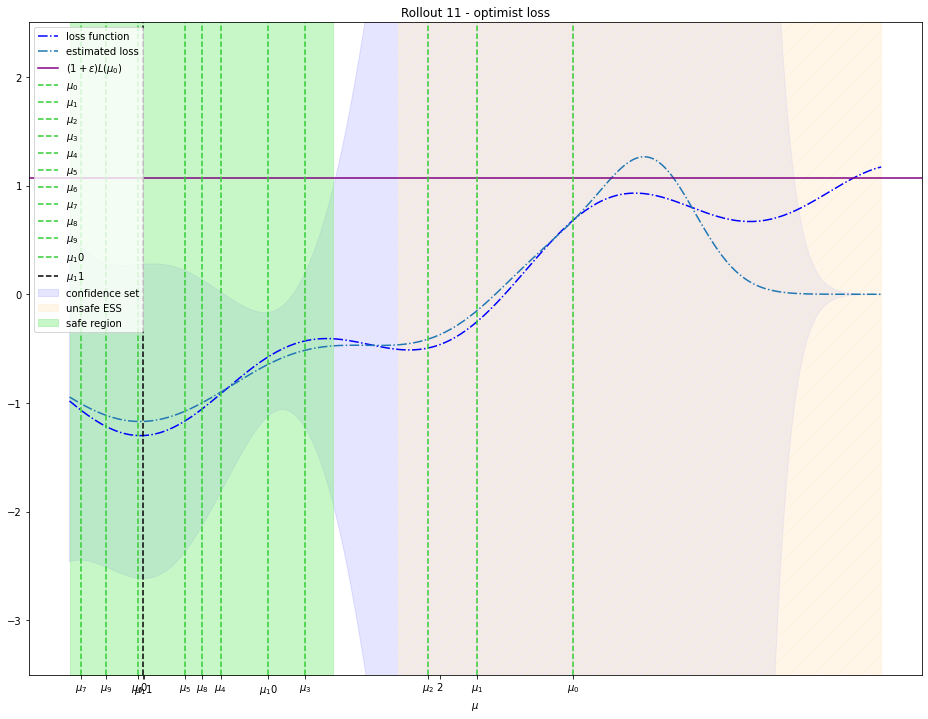

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


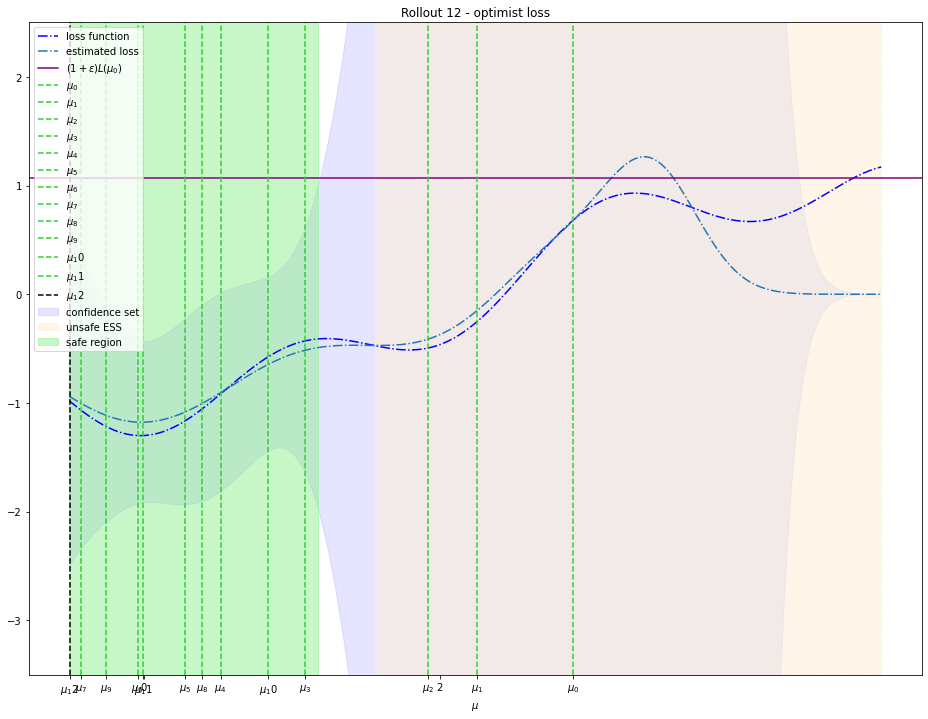

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


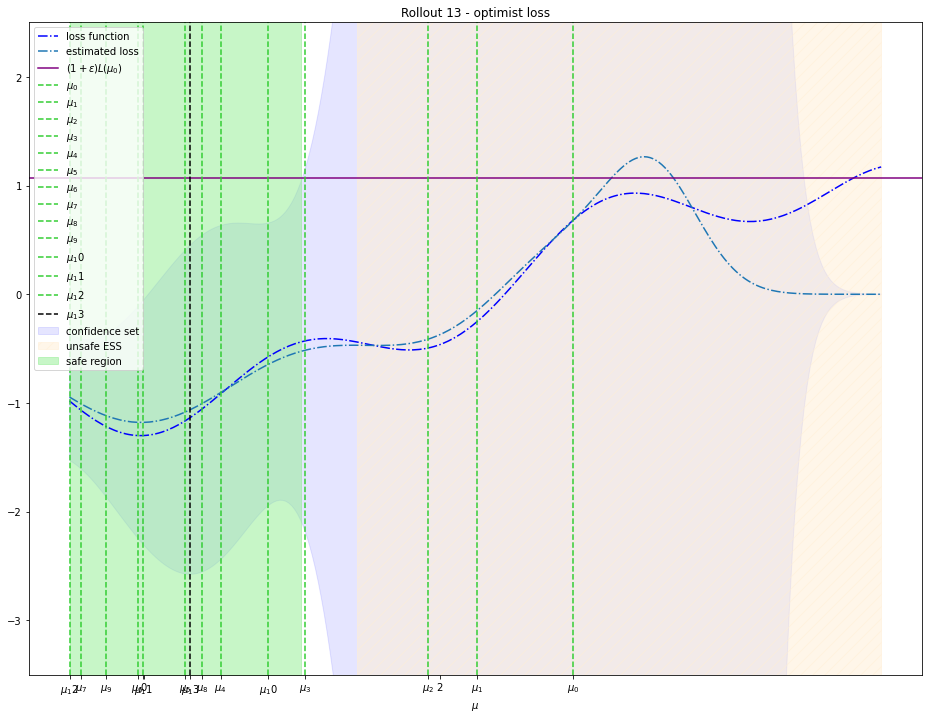

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


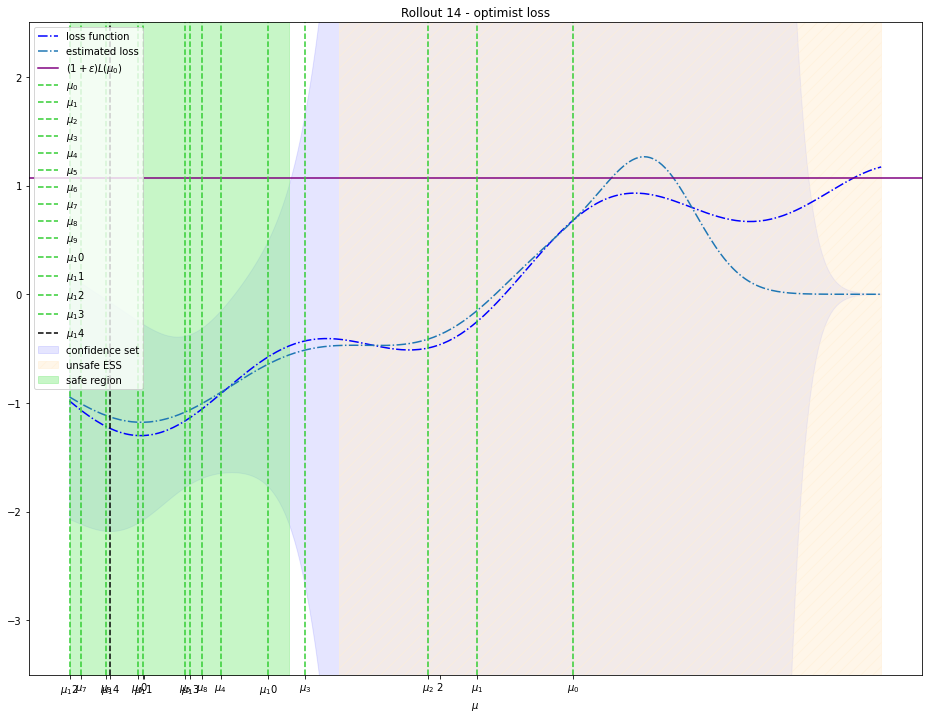

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


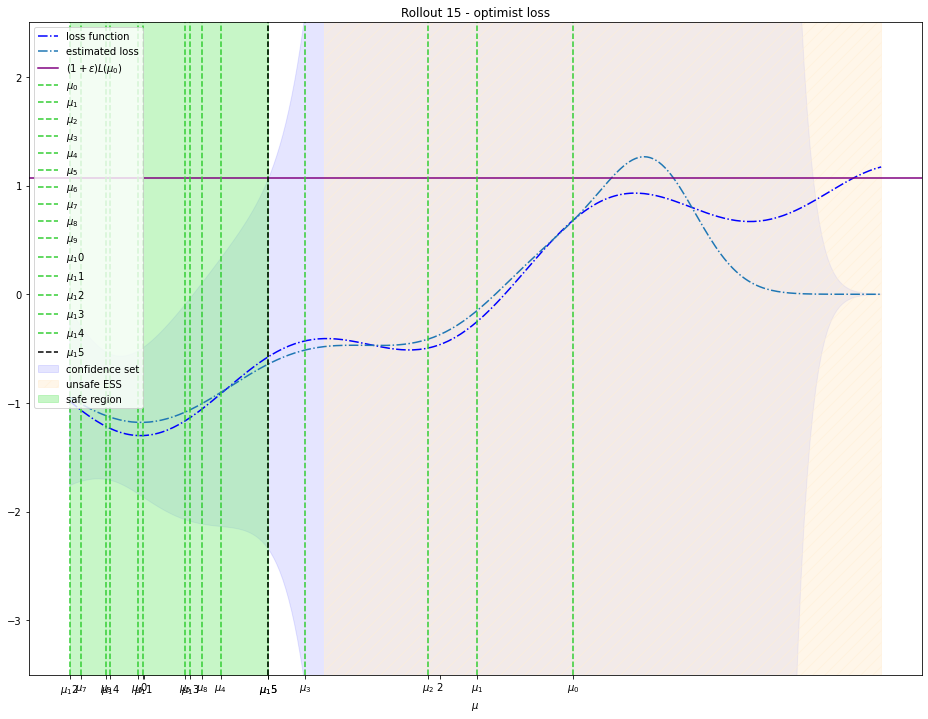

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


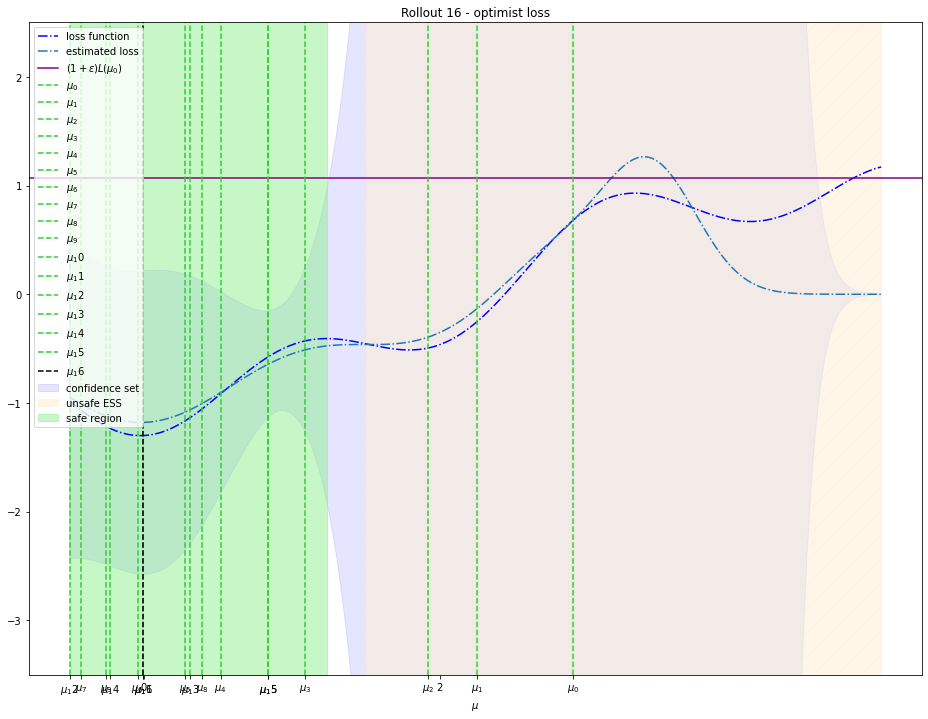

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


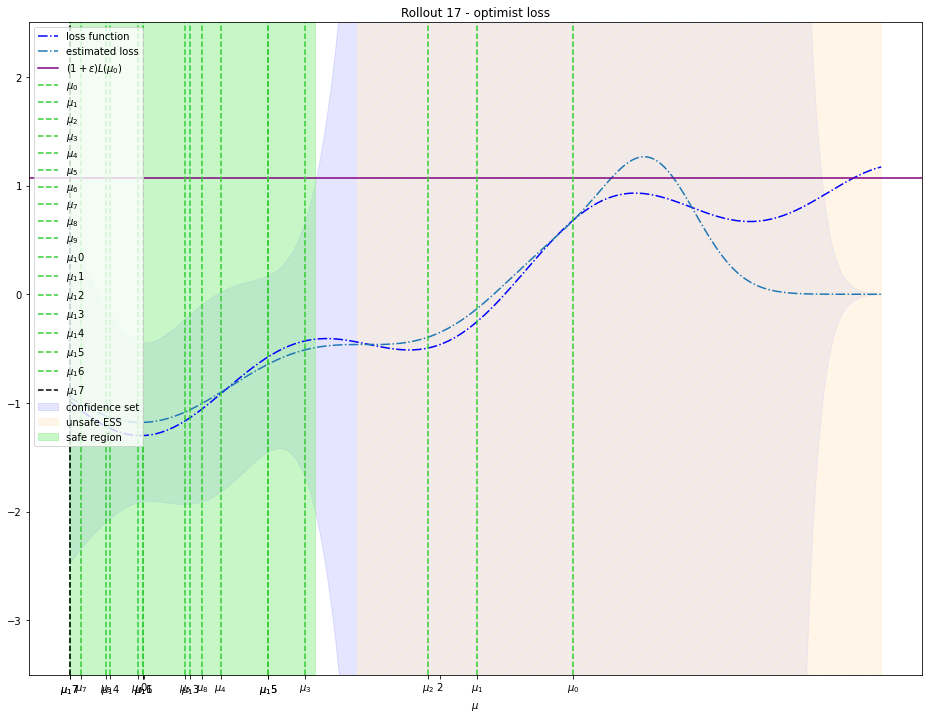

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


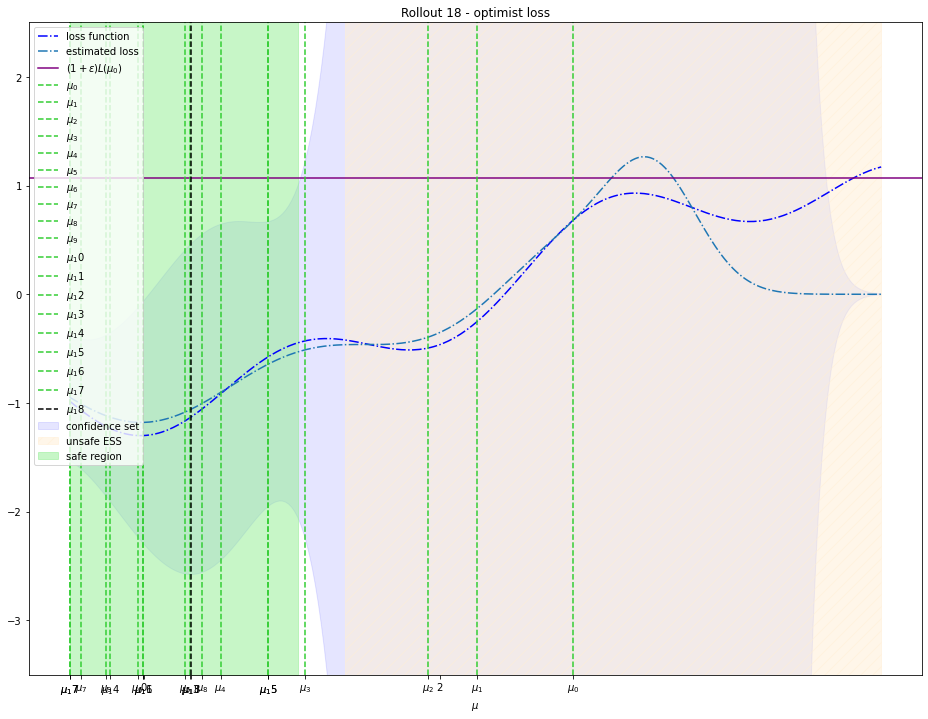

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_68112/4276857251.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data.tolist() + [samples])


KeyboardInterrupt: 

In [26]:
mode = 'optimist'
loss_fun = optimist_mixture_loss



for m in range(M):

    number_samples = number_samples* 2
    all_logging_samples, all_losses, all_logging_propensities = get_all_data(logging_samples, logging_losses, logging_propensities)
    mixture_logging_propensities = get_mixture_logging_propensities(optimized_mus, n_samples, all_logging_samples)
    
    ### Logging data with mixture propensities
    logging_data = all_logging_samples, all_losses, mixture_logging_propensities
    
    def get_estimates(mu, logging_data):

        def estimates(mu, logging_data):
            logging_samples, logging_losses, logging_propensities = logging_data
            running_pdf = norm(loc=mu, scale=logging_scale).pdf
            importance_weights = running_pdf(logging_samples)/logging_propensities
            ess_diagnostic = (np.sum(importance_weights)**2)/np.sum(importance_weights**2)/number_samples
            stds = np.sqrt(np.sum(np.cov(logging_losses * importance_weights)))
            return np.mean(logging_losses * importance_weights), stds, ess_diagnostic

        estimate_means, estimate_stds, ess_diagnostics = zip(*[estimates(mu, logging_data) for mu in mus])
        estimate_means, ess_diagnostics = np.array(estimate_means), np.array(ess_diagnostics)
        upper_bounds = estimate_means+estimate_stds
        confidence_region = ((upper_bounds<logging_loss_threshold)&(ess_diagnostics>0.01))

        estimates = {
            'means': estimate_means,
            'stds': estimate_stds,
            'ess': ess_diagnostics,
            'confidence_region': confidence_region
        }

        return estimates

    estimates = get_estimates(mu, logging_data)
    confidence_region = estimates['confidence_region']
    init_parameter = jnp.array(mu, dtype='float32')
    args = logging_data

    optimized_mu = safe_optimize(loss_fun, init_parameter, logging_loss_threshold, confidence_region, args)
    optimized_mus.append(optimized_mu)
    plot_dynamic(estimates, optimized_mus, mode)

    ### New logging data
    mu = optimized_mu._value
    policy_samples = rng.normal(loc=mu, scale=logging_scale, size=number_samples)
    loss_samples = true_loss_function(policy_samples)
    policy_pdf = norm(loc=mu, scale=logging_scale).pdf
    propensities = policy_pdf(policy_samples)
    
    logging_samples = update_past_data(logging_samples, policy_samples)
    logging_losses = update_past_data(logging_losses, loss_samples)
    logging_propensities = update_past_data(logging_propensities, propensities)
    n_samples = np.concatenate([n_samples, [[number_samples]]], axis=0)
    

In [27]:
logging_samples.shape

(19,)

In [28]:
logging_samples

array([list([2.6743108190098317, 3.299203633975076, 3.0848935494155976, 2.5481115858245724, 2.8264199244094392, 3.4954309611291454, 2.2719962269820777, 2.871326211343147, 3.37978087761166, 2.7399778793204694]),
       array([2.04580868, 2.22106183, 2.69689141, 2.05780393, 2.11627994,
              2.11916914, 2.91125355, 2.90551035, 2.55069069, 2.36533045,
              2.4706851 , 2.69669413, 1.96872436, 2.60222324, 1.87331033,
              2.05814907, 2.52160608, 1.82087032, 2.20745391, 1.99094806]),
       array([1.84668336, 1.08379244, 1.39190924, 1.713406  , 2.2016079 ,
              1.87127846, 1.92422294, 2.12983598, 1.65950827, 2.00845737,
              1.68175921, 1.40506832, 1.80609923, 2.09551093, 2.02494588,
              1.91982002, 2.64107875, 2.04724282, 2.21698997, 2.59481217,
              1.53514357, 1.61173271, 2.44648284, 1.68395035, 1.93227414,
              2.24416396, 2.19058109, 2.44983502, 2.37206241, 2.24418697,
              1.69155655, 2.16182797, 2.0176507

In [58]:
all_actions = np.concatenate(actions)

In [14]:
logging_propensities

array([array([6.92835726e-02, 8.29472214e-01, 8.37686426e-03, 2.28960184e-02,
              6.78795009e-02, 5.89138152e-01, 1.91869271e-01, 1.64858699e-01,
              6.23754148e-01, 9.15460606e-03, 1.70088188e-01, 6.71903090e-03,
              8.61142697e-01, 4.94636147e-02, 5.11896973e-03, 3.37506512e-01,
              1.03755635e+00, 1.83212936e-01, 4.18688432e-02, 4.68517140e-02,
              6.11521508e-01, 3.76695827e-01, 1.73467367e-03, 4.73229060e-01,
              7.99592427e-01, 1.91708827e-01, 5.33350537e-03, 2.30315908e-01,
              1.44439235e-01, 1.05981143e-02, 4.12425967e-01, 3.38572052e-01,
              4.20125589e-02, 4.27728984e-01, 6.95901893e-01, 9.87876185e-01,
              2.28471549e-02, 1.39356981e-01, 2.74430872e-02, 5.09036784e-03,
              5.82131090e-01, 1.52381132e-01, 8.34991941e-02, 1.20201307e-02,
              9.08956070e-01, 8.18871172e-03, 3.83836876e-01, 5.12987878e-01,
              1.05945370e+00, 8.55155825e-01, 2.09338232e-02, 2.

In [59]:
all_logging_propensities = np.concatenate(logging_propensities)
all_losses = np.concatenate(losses)

In [60]:
running_pdf = norm(loc=2.1, scale=logging_scale).pdf
all_importance_weights = running_pdf(all_actions)/all_logging_propensities

In [61]:
pi_t = np.array([distribution(all_actions) for distribution in distributions])
n_pi_t = n_samples * pi_t
sum_n_pi_t = np.sum(n_pi_t, axis=0)
all_omegas = all_logging_propensities / sum_n_pi_t

In [62]:
multi_ips_mean = np.sum(all_omegas * all_losses * all_importance_weights)

In [63]:
multi_ips_mean

0.34378776090288393

In [49]:
pi_t

array([[0.06928357, 0.82947221, 0.00837686, ..., 1.01099505, 0.30327235,
        0.03552803],
       [1.32349621, 0.52617088, 0.92649002, ..., 0.37393352, 1.10139072,
        1.24712616],
       [0.88498962, 0.08176827, 1.31496271, ..., 0.04611549, 0.36154622,
        1.08236687]])

In [54]:
alpha_t = n_samples/ np.sum(n_samples)
alpha_t, alpha_t * pi_t, np.sum(alpha_t * pi_t, axis=0)

(array([[0.07692308],
        [0.15384615],
        [0.76923077]]),
 array([[5.32950559e-03, 6.38055549e-02, 6.44374173e-04, ...,
         7.77688498e-02, 2.33286423e-02, 2.73292562e-03],
        [2.03614801e-01, 8.09493665e-02, 1.42536926e-01, ...,
         5.75282337e-02, 1.69444727e-01, 1.91865563e-01],
        [6.80761247e-01, 6.28986685e-02, 1.01150977e+00, ...,
         3.54734554e-02, 2.78112474e-01, 8.32589901e-01]]),
 array([0.88970555, 0.20765359, 1.15469107, ..., 0.17077054, 0.47088584,
        1.02718839]))

In [66]:
pi_t = np.array([distribution(all_actions) for distribution in distributions])
alpha_t = n_samples/ np.sum(n_samples)
mixture_logging_propensities = np.sum(alpha_t * pi_t, axis=0)
logging_samples = all_actions
logging_losses = all_losses
mixture_importance_weights = pdf(2.1, logging_samples)/mixture_logging_propensities
mixture_ips_mean = np.mean(logging_losses * mixture_importance_weights)
mixture_ips_std = np.sqrt(np.sum(np.cov(logging_losses * mixture_importance_weights)))

In [67]:
mixture_ips_mean

DeviceArray(0.34378776, dtype=float32)

In [108]:
mixture_importance_weights.shape

(1300,)

In [116]:
n_pi_t.shape, n_pi_t

((3, 1300),
 array([[1.18947863e-01, 5.42515738e-01, 1.95987327e-01, ...,
         8.07785300e+00, 7.97203821e+01, 7.33246692e-02],
        [9.79444354e+01, 1.63924155e+02, 1.17571586e+02, ...,
         2.65811841e+02, 1.11038576e+02, 8.11965584e+01],
        [1.22085910e+03, 1.32963348e+03, 1.27949532e+03, ...,
         8.33622635e+02, 8.98008105e+01, 1.14911973e+03]]))

In [36]:
np.sum(n_pi_t, axis=0).shape, np.sum(n_pi_t, axis=1)

((1300,), array([1.49116842e-08, 7.61894213e-02, 4.21395176e+01]))

In [42]:
a = np.array([[1, 2, 3, 4, 5], [10, 20, 30, 40, 50], [4, 8, 16, 32, 64]])
b = np.array([10, 2, 3, 4, 10])
a.shape, b.shape

((3, 5), (5,))

In [44]:
c = a/b

In [45]:
c.shape

(3, 5)

### Covariance

In [26]:
X = np.array([ [0.1, 0.3, 0.4, 0.8, 0.9],
               [3.2, 2.4, 2.4, 0.1, 5.5],
               [10., 8.2, 4.3, 2.6, 0.9]
             ])
X.shape

(3, 5)

In [22]:
print( np.cov(X) )

[[ 0.115   0.0575 -1.2325]
 [ 0.0575  3.757  -0.8775]
 [-1.2325 -0.8775 14.525 ]]


In [31]:
X = np.concatenate([np.random.uniform(size=(1,1000)) for _ in range(3)], axis=0)
X.shape

(3, 1000)

In [32]:
print( np.cov(X) )

[[ 0.08237449  0.00363606  0.00150382]
 [ 0.00363606  0.08682408 -0.00091219]
 [ 0.00150382 -0.00091219  0.08640116]]


In [39]:
data = np.random.random((2, 100))

print(np.cov(data))

[[ 0.08970914 -0.008125  ]
 [-0.008125    0.08486774]]


In [40]:
np.sum(np.cov(data))

0.1583268675843964

In [41]:
np.var(data[0]), np.var(data[1])

(0.08881204969181386, 0.08401905772612002)

In [43]:
np.sqrt(np.sum(np.cov(data))), np.sqrt(np.var(data[0])+np.var(data[1]))

(0.3979030881815274, 0.4157296085413377)